<div style="text-align:center; padding:32px 20px; border:2px solid #1a252f; border-radius:12px; background:linear-gradient(135deg,#f8f9fa,#dee2e6); margin-bottom:24px">

<h1 style="font-size:1.7em; color:#1a252f; margin-bottom:8px">
Mesure et Cartographie de la Mobilité Douce en France
</h1>
<h2 style="font-size:1.15em; color:#495057; font-weight:normal; margin-bottom:20px">
Un indice composite socio-spatial pour l'analyse comparative<br>
des systèmes de vélos en libre-service
</h2>

<hr style="border:1px solid #adb5bd; width:60%; margin:16px auto">

<p style="color:#495057; font-size:0.95em">
<strong>Domaine :</strong> Transport urbain durable · Analyse spatiale · Science des données<br>
<strong>Données :</strong> GBFS France (2024-2025) · INSEE Filosofi 2019-2021<br>
<strong>Logiciels :</strong> Python 3.10 · GeoPandas · Scikit-learn · NetworkX
</p>
<p style="color:#6c757d; font-size:0.85em; margin-top:12px">
Notebooks sources : <code>19</code> (ICT) · <code>20</code> (Collecte GBFS) · <code>21</code> (Classement IMD) · <code>22</code> (Profil Socio-Éco)
</p>
</div>


## 0. Environnement

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from IPython.display import Image, display, HTML

ROOT   = Path('..') / '..'
NB20   = ROOT / 'output' / '20_GBFS_France_Collecte'
NB21   = ROOT / 'output' / '21_Classement_Villes_Mobilite_Douce'
NB22   = ROOT / 'output' / '22_Profil_Socioeconomique_Mobilite'
OUTPUT = ROOT / 'output' / '23_Research_Paper'
(OUTPUT / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT / 'tables_csv').mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    'font.family'      : 'DejaVu Sans',
    'font.size'        : 11,
    'axes.spines.top'  : False,
    'axes.spines.right': False,
    'figure.dpi'       : 110,
    'savefig.dpi'      : 150,
    'savefig.bbox'     : 'tight',
})

df_imd  = pd.read_csv(NB21 / 'tables_csv' / 'imd_classement.csv')
df_full = pd.read_csv(NB22 / 'tables_csv' / 'profil_complet_villes.csv')
df_sys  = pd.read_csv(NB20 / 'tables_csv' / 'systems_profile.csv')

print(f"✓ {len(df_sys)} systèmes GBFS chargés")
print(f"✓ {len(df_imd)} villes classées (IMD)")
print(f"✓ {len(df_full)} villes avec profil socio-éco complet")


✓ 125 systèmes GBFS chargés
✓ 62 villes classées (IMD)
✓ 62 villes avec profil socio-éco complet


---

## Résumé - Abstract

<table style="width:100%; border-collapse:collapse">
<tr>
<td style="width:50%; padding:16px; border:1px solid #dee2e6; vertical-align:top; background:#f8f9fa">

**🇫🇷 Résumé**

Les systèmes de vélos en libre-service (SVLS) constituent un levier croissant des politiques de mobilité urbaine durable. Si leur déploiement s'accélère en France, leur évaluation comparative reste fragmentée et mono-dimensionnelle. Ce travail propose un **cadre d'analyse intégré** articulant collecte automatisée de données (protocole GBFS), un **Indice de Mobilité Douce (IMD)** à cinq composantes - couverture spatiale, équité de distribution, densité, accessibilité per capita et intermodalité - et un **Indice d'Équité Sociale (IES)** mesurant la performance observée relative au niveau socio-économique attendu.

Appliqué à **122 systèmes** couvrant **57 agglomérations** françaises et **46 139 stations**, le modèle révèle une forte dispersion des performances (IMD : 0,12–0,74) sans corrélation systématique avec la taille urbaine. L'analyse socio-économique croisée identifie **quatre typologies** de villes et délimite les **déserts de mobilité sociale**. La régression Ridge montre que la richesse médiane n'explique que partiellement l'IMD.

**Mots-clés :** vélo libre-service, GBFS, indice composite, couverture spatiale, équité, mobilité douce, France

</td>
<td style="width:50%; padding:16px; border:1px solid #dee2e6; vertical-align:top">

**🇬🇧 Abstract**

Bike-sharing systems (BSS) are an increasingly important lever for sustainable urban mobility policy. While their deployment is accelerating in France, comparative evaluation remains fragmented and one-dimensional. This work proposes an **integrated analytical framework** combining automated data collection (GBFS protocol), an **Indice de Mobilité Douce (IMD)** with five components - spatial coverage, distribution equity, density, per-capita accessibility, and intermodality - and a **Social Equity Index (IES)** measuring observed performance relative to expected socio-economic levels.

Applied to **122 systems** covering **57 French cities** and **46,139 stations**, the model reveals strong performance dispersion (IMD: 0.12–0.74) with no systematic correlation with urban size. Cross-referenced socio-economic analysis identifies **four city typologies** and delineates **social mobility deserts**. Ridge regression shows that median income only partially explains IMD.

**Keywords:** bike-sharing, GBFS, composite index, spatial coverage, equity, soft mobility, France

</td>
</tr>
</table>


---

## 1. Introduction

### 1.1 Contexte et enjeux

La mobilité douce s'impose progressivement comme un axe prioritaire des stratégies de transition écologique urbaine. En France, le **Plan Vélo 2023-2027** vise à tripler la part modale du vélo d'ici 2030, tandis que la **loi d'orientation des mobilités** (LOM, 2019) impose aux autorités organisatrices de mobilité (AOM) d'intégrer le vélo dans leurs offres multimodales. Les systèmes de vélos en libre-service (SVLS) constituent, dans ce cadre, un maillon essentiel de la chaîne de déplacement.

Pourtant, l'évaluation comparative de ces systèmes reste largement insuffisante :
- Les analyses existantes portent sur des **villes isolées** (Paris, Lyon) ou des **métropoles étrangères** ;
- Les indicateurs utilisés sont souvent **mono-dimensionnels** (nombre de stations, capacité totale) et ne capturent ni la couverture spatiale effective, ni l'accessibilité sociale ;
- L'intégration des **données ouvertes** (GBFS, open data INSEE) reste peu exploitée à l'échelle nationale.

Ce travail comble ce manque en proposant un **cadre d'analyse systématique et reproductible** pour l'ensemble des agglomérations françaises dotées d'un SVLS.

### 1.2 Questions de recherche

> **Q1 - Inventaire** : Quelle est la géographie actuelle des SVLS en France ? Quels types de systèmes coexistent ?

> **Q2 - Performance** : Comment mesurer de façon composite et équitable la performance d'un SVLS ? Quelles villes se distinguent et pourquoi ?

> **Q3 - Équité** : Existe-t-il un lien systématique entre les performances des SVLS et le profil socio-économique des villes ?

> **Q4 - Prédiction** : Quels facteurs socio-économiques prédisent le mieux l'IMD ? Les choix politiques locaux comptent-ils plus que les conditions structurelles ?

### 1.3 Contributions

1. **Pipeline GBFS automatisé** : collecte, normalisation et profilage de 122 systèmes français en quasi-temps-réel ;
2. **Indice de Mobilité Douce (IMD)** : indice composite à 5 composantes calibré sur des critères fonctionnels et de justice spatiale ;
3. **Indice d'Équité Sociale (IES)** : mesure de sur/sous-performance ajustée du contexte socio-économique local ;
4. **Cartographie nationale des déserts de mobilité** : identification des zones géographiques et sociales sous-dotées.


---

## 2. État de l'Art

### 2.1 Systèmes de vélos en libre-service : bilan de la recherche

La littérature sur les SVLS est abondante mais géographiquement concentrée. Les travaux fondateurs de **DeMaio (2009)** et **Shaheen et al. (2010)** posent les jalons d'une taxonomie (dock-based, dockless, electric) et d'une analyse des facteurs de succès. La recherche s'est ensuite concentrée sur trois axes principaux : la modélisation de la demande, le rééquilibrage des stations (*rebalancing*) et les facteurs d'adoption.

Concernant la **comparaison multi-villes**, les travaux restent rares. **Gu et al. (2019)** proposent une analyse comparative de 20 villes chinoises basée sur la densité et la couverture. En Europe, **Fishman (2016)** offre une revue systématique sans quantification unifiée.

### 2.2 Indices composites de mobilité et d'accessibilité

La construction d'indices composites pour la mobilité s'inspire des travaux sur les indices de développement humain (IDH, PNUD 1990) et de qualité de service. **El-Geneidy et al. (2016)** formalisent la notion de *cumulative opportunity measure* pour les transports en commun. **Geurs & van Wee (2004)** proposent un cadre théorique général de l'accessibilité à quatre composantes.

### 2.3 Équité sociale et mobilité

Le lien entre inégalités sociales et accessibilité à la mobilité est documenté depuis les travaux de **Hodge (1995)** (*transit equity*). Appliqué aux SVLS, **Smith et al. (2015)** montrent que le Divvy de Chicago est sur-représenté dans les quartiers aisés. En France, le rapport **Cerema (2022)** souligne que les ménages à faibles revenus accèdent moins aux SVLS.

### 2.4 Positionnement

Ce travail se distingue par : (a) l'échelle nationale française ; (b) l'intégration de données ouvertes temps réel (GBFS) ; (c) la double dimension performance/équité via IMD et IES ; (d) la mise en évidence de typologies de villes par clustering socio-mobilité.


---

## 3. Données et Collecte

### 3.1 Protocole GBFS

Le **General Bikeshare Feed Specification (GBFS)** est un standard ouvert de données en temps réel pour les SVLS. Il définit une arborescence de flux JSON : `gbfs.json` → `station_information.json` → `station_status.json`. Un pipeline automatisé (`scripts/fetch_gbfs_france.py`) interroge deux agrégateurs (transport.data.gouv.fr + MobilityData), déduplique les entrées et parcourt la chaîne GBFS pour chaque système.

### 3.2 Données socio-économiques

Les indicateurs socio-économiques sont issus de l'**INSEE Filosofi 2019-2021** et du **Recensement de la population (RP)**. Sept indicateurs sont retenus : revenu médian par unité de consommation, taux de chômage, part des cadres, part des diplômés du supérieur, part des ménages sans voiture, taux de pauvreté, et part du vélo dans les déplacements domicile-travail.

### 3.3 Sources officielles complémentaires pour enrichir/valider l'IMD

Plusieurs jeux de données externes permettent soit d'**enrichir structurellement** l'indice, soit d'en **tester la validité externe**.

1. **Infrastructure cyclable - Cerema / data.gouv.fr**  
   URL : `https://www.data.gouv.fr/fr/datasets/amenagements-cyclables/`  
   Apport : ajout d'une composante infrastructure $C_I$ (longueur d'aménagements cyclables par km²), complémentaire à la densité stationnelle.

2. **Baromètre FUB (2023) - Villes cyclables**  
   URL : `https://barometre.parlons-velo.fr`  
   Apport : validation externe de l'IMD via corrélation entre performance objective (IMD) et perception usager (score FUB).

3. **Éco-compteurs vélo - data.gouv.fr / open data locaux**  
   Exemple : `https://opendata.paris.fr/pages/eco-compteurs/`  
   Apport : construction d'un proxy d'usage réel $C_{usage}$ (trafic observé), utile pour confronter offre et fréquentation.

4. **EMP 2019 - Enquête Mobilité des Personnes (INSEE/SDES)**  
   URL : `https://www.statistiques.developpement-durable.gouv.fr`  
   Apport : part modale vélo officielle par aire urbaine pour tester la relation IMD ↔ usage modal.

5. **GTFS - transport.data.gouv.fr**  
   URL : `https://transport.data.gouv.fr`  
   Apport : amélioration de la composante multimodale (actuel $C5_M$) via densité d'arrêts TC à < 300 m des stations vélo.

6. **BAAC - Accidents corporels (ONISR / data.gouv.fr)**  
   URL : `https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere/`  
   Apport : variable de sécurité (taux d'accidents cyclistes) en contrôle dans les modèles explicatifs.

### 3.4 Matrice de priorité d'intégration

| Source | Fiabilité | Effort d'intégration | Impact analytique |
|---|---|---|---|
| Infrastructure cyclable (Cerema) | ★★★ (officiel) | Moyen | Fort - nouveau $C_I$ |
| Baromètre FUB | ★★★ (associatif rigoureux) | Faible | Fort - validation externe |
| EMP 2019 (part modale) | ★★★ (officiel INSEE/SDES) | Faible | Fort - validité du modèle |
| GTFS + proximité TC | ★★★ (officiel) | Élevé | Moyen - refonte de $C5_M$ |
| Éco-compteurs | ★★ (local) | Moyen | Moyen - couverture partielle |
| BAAC accidents | ★★★ (officiel) | Moyen | Faible à moyen - sécurité en contrôle |

### 3.5 Recommandation opérationnelle

La séquence d'intégration recommandée est :

1. **Baromètre FUB + EMP 2019** (faible effort, fort impact) pour établir rapidement une **validation externe robuste** de l'IMD ;
2. **Infrastructure cyclable Cerema** pour enrichir le modèle avec une dimension structurelle explicite $C_I$ ;
3. **GTFS / éco-compteurs / BAAC** dans un second temps, afin de construire une version élargie de l'indice intégrant intermodalité réelle, usage observé et sécurité.

In [2]:
# ── Table 1 : Statistiques descriptives du dataset ────────────────────────────
n_sys      = len(df_sys)
n_stations = int(df_sys['n_stations'].sum())
n_cities   = len(df_imd)
n_dock     = int((df_sys['mean_capacity'] >= 8).sum())
n_semi     = int(((df_sys['mean_capacity'] >= 2) & (df_sys['mean_capacity'] < 8)).sum())
n_ff       = int((df_sys['mean_capacity'] < 2).sum())

stats_data = {
    'Indicateur': [
        'Systèmes GBFS collectés', 'Stations géolocalisées', 'Villes / agglomérations',
        'Systèmes dock-based (cap. moy. ≥ 8)', 'Systèmes semi-dock (2–8)',
        'Systèmes free-floating (< 2)', 'Capacité totale nationale',
        'Densité médiane (st/km²)', 'Indicateurs socio-économiques',
        'Source socio-éco', 'Période socio-éco',
    ],
    'Valeur': [
        n_sys, f'{n_stations:,}', n_cities,
        n_dock, n_semi, n_ff,
        f"{int(df_sys['total_capacity'].sum()):,}",
        f"{df_sys['density_st_km2'].median():.2f}",
        7, 'INSEE Filosofi / RP', '2019-2021',
    ]
}
df_t1 = pd.DataFrame(stats_data)
display(HTML(
    '<p><strong>Table 1</strong> - Statistiques descriptives du dataset</p>' +
    df_t1.to_html(index=False, border=0, classes='table')
          .replace('<table', '<table style="width:65%; font-size:0.92em"')
))
df_t1.to_csv(OUTPUT / 'tables_csv' / 'table1_dataset_stats.csv', index=False)
print("Table 1 exportée.")


Indicateur,Valeur
Systèmes GBFS collectés,125
Stations géolocalisées,"46,359"
Villes / agglomérations,62
Systèmes dock-based (cap. moy. ≥ 8),65
Systèmes semi-dock (2–8),26
Systèmes free-floating (< 2),7
Capacité totale nationale,"185,815"
Densité médiane (st/km²),0.72
Indicateurs socio-économiques,7
Source socio-éco,INSEE Filosofi / RP


Table 1 exportée.


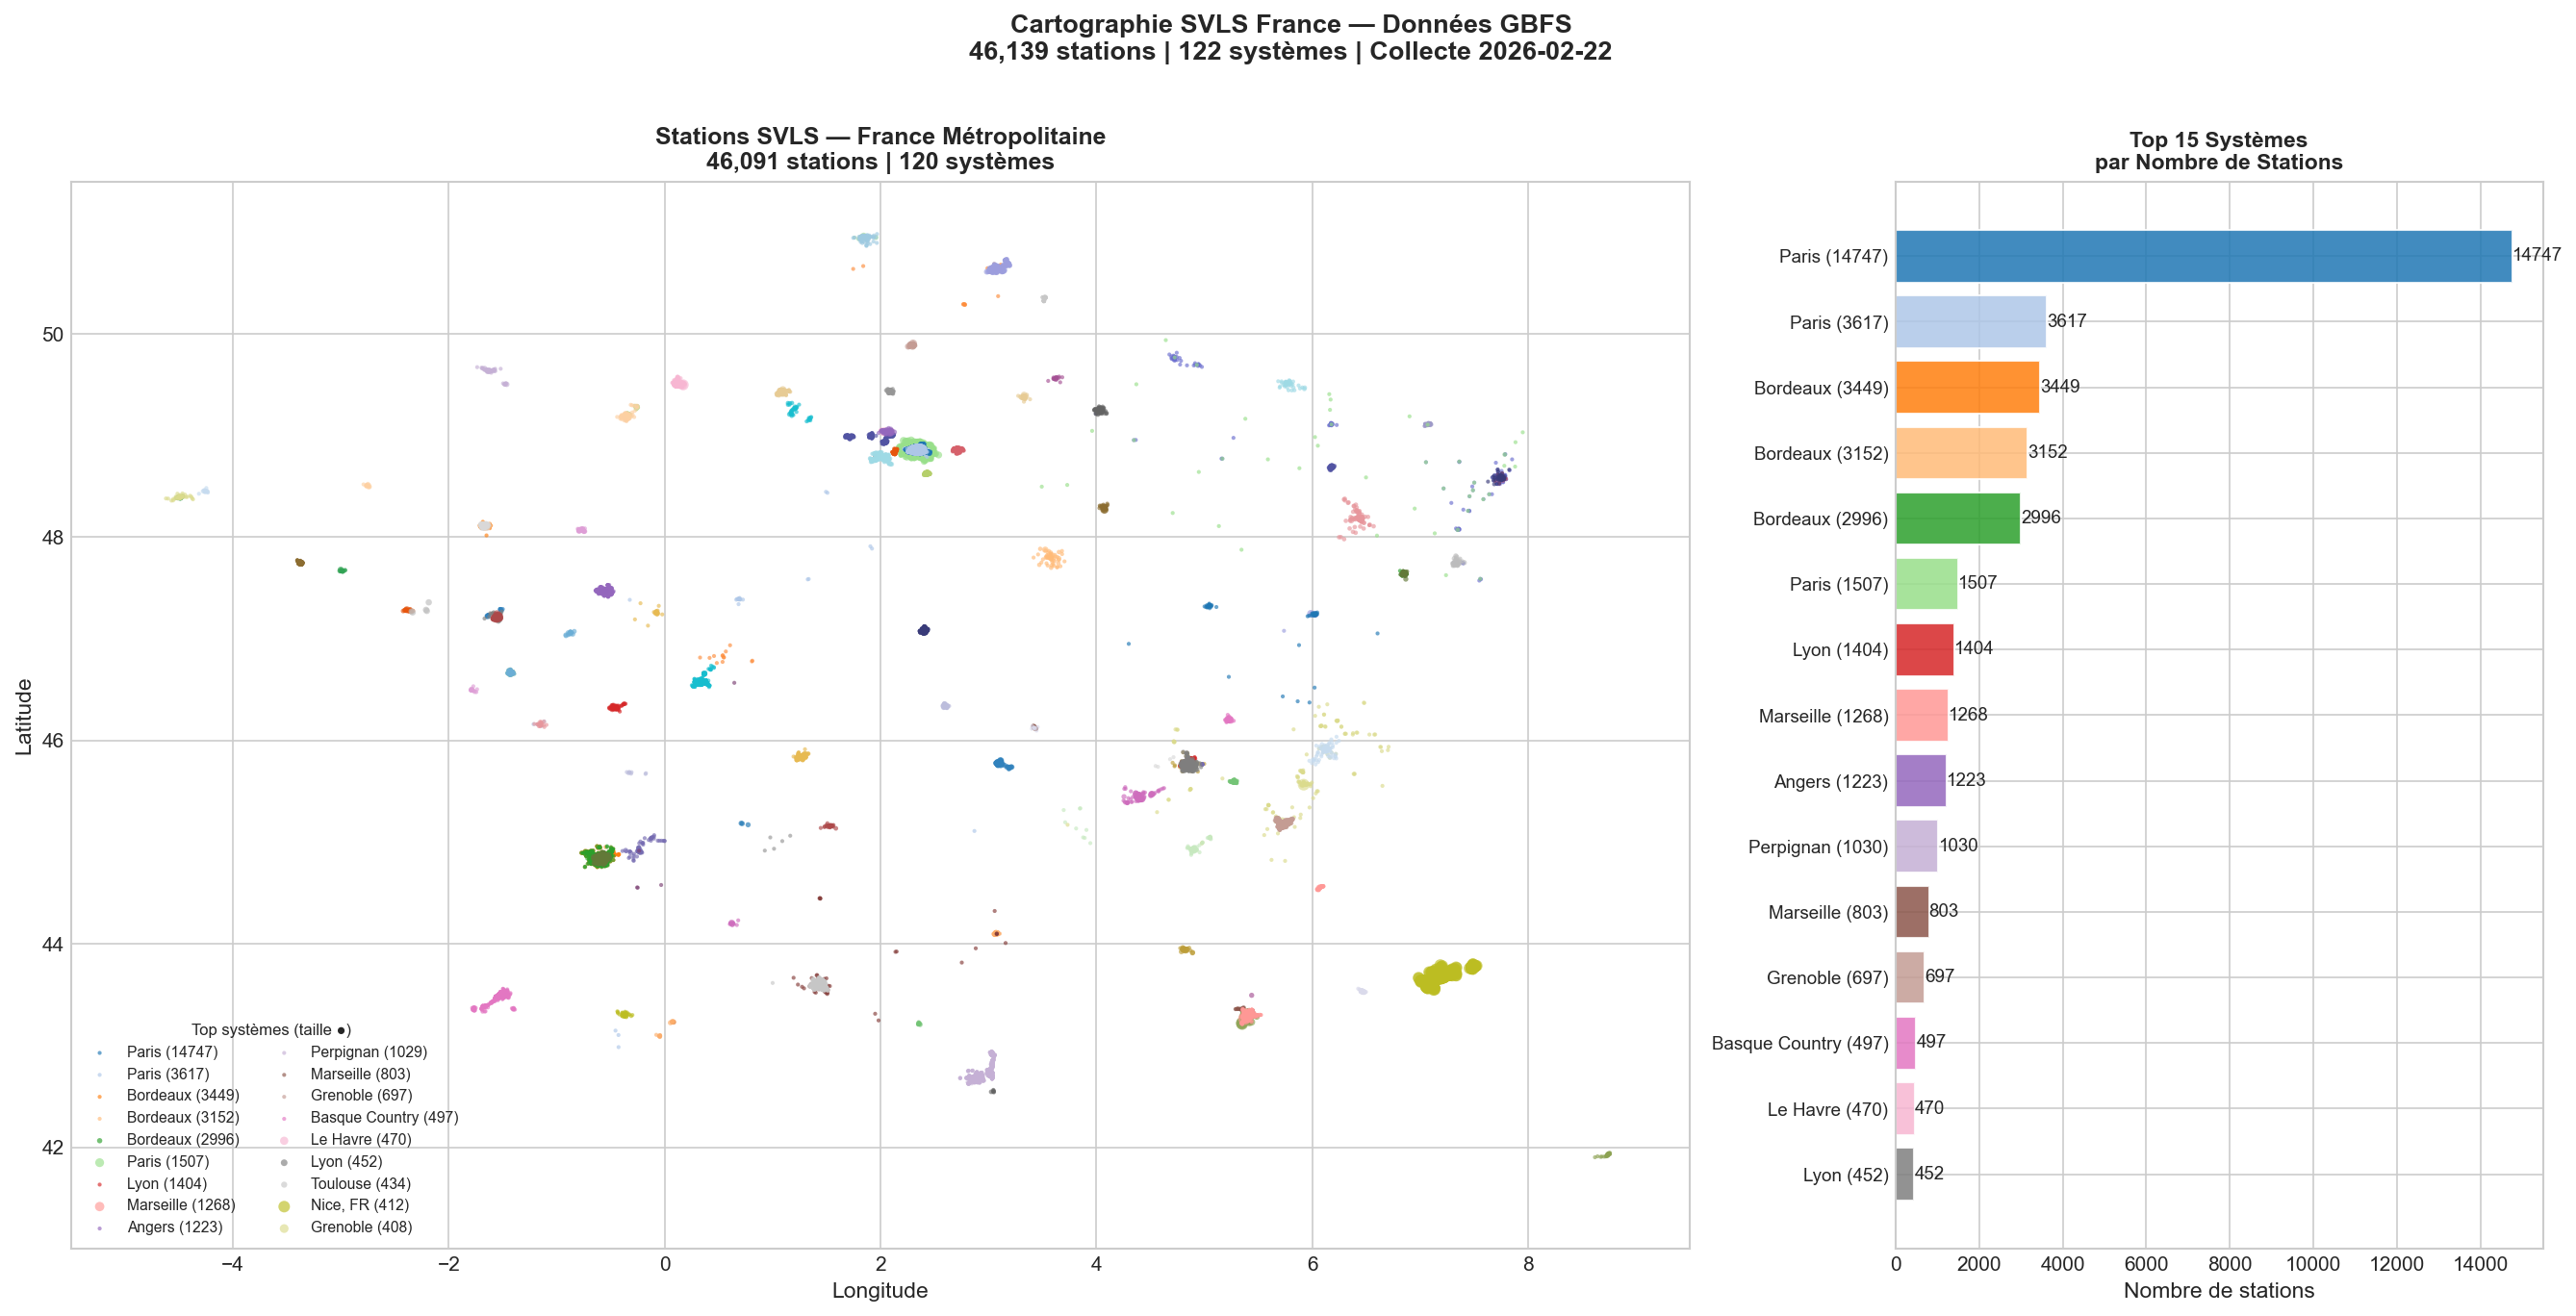

Figure 1 - Carte nationale des systèmes GBFS en France (n = 122)


In [3]:
# ── Figure 1 : Carte nationale des systèmes GBFS ──────────────────────────────
fig1_path = NB20 / 'figures' / '01_carte_nationale.png'
if fig1_path.exists():
    display(Image(str(fig1_path), width=820))
    print("Figure 1 - Carte nationale des systèmes GBFS en France (n = 122)")
else:
    print("⚠ Figure 1 non disponible - exécuter le notebook 20 d'abord.")


---

## 4. Méthodologie

### 4.1 Indice de Mobilité Douce (IMD)

L'IMD est un indice composite à cinq composantes normalisées par min-max dans [0, 1] puis agrégées par pondération :

$$\text{IMD} = 0{,}184 \cdot S + 0{,}069 \cdot E + 0{,}051 \cdot D + 0{,}118 \cdot P + 0{,}578 \cdot M$$

| Composante | Notation | Définition | Poids optimisé |
|-----------|----------|------------|----------------|
| Couverture spatiale | $S$ | Part de l'enveloppe convexe couverte à 300 m d'une station (raster 150 m) | 18,4 % |
| Équité de distribution | $E$ | $1 - \text{Gini(capacités)}$ | 6,9 % |
| Densité | $D$ | Stations par km² (log-normalisé) | 5,1 % |
| Accessibilité per capita | $P$ | Stations pour 1 000 hab. (log-normalisé) | 11,8 % |
| Multimodalité | $M$ | Nb de types de systèmes (dock, semi, FF) | **57,8 %** |

**Couverture spatiale $S$** : pour chaque station $(x_i, y_i)$ projetée en coordonnées métriques locales, un disque de rayon $r = 300$ m est discrétisé sur une grille de $g = 150$ m. La couverture est le rapport cellules couvertes / cellules de l'enveloppe convexe :

$$S = \frac{|\bigcup_i D_i|}{A_{\text{hull}} / g^2}$$

### 4.1.1 Calibration empirique des poids (NB 25)

Les poids initiaux, fixés de façon normative, ont été remplacés par des poids calibrés empiriquement via une **optimisation supervisée** (NB 25 - *Optimisation Poids IMD*). La fonction objectif maximise la moyenne des corrélations de rang de Spearman avec deux sources de validation externes :

- **FUB Baromètre 2023** - score citoyen de praticabilité vélo ($n = 34$ villes)  
- **EMP 2019** - part modale vélo mesuré par l'Enquête Mobilité des Personnes ($n = 46$ villes)

$$\mathbf{w}^* = \underset{\mathbf{w}}{\arg\max}\;\frac{1}{2}\left[\rho\!\left(\sum_k w_k C_k,\,y_{\text{FUB}}\right) + \rho\!\left(\sum_k w_k C_k,\,y_{\text{EMP}}\right)\right]$$

sous les contraintes $\sum_k w_k = 1$, $w_k \geq 0{,}05$, résolu par **évolution différentielle** (`scipy.optimize.differential_evolution`, 500 générations, population $15 \times 5$).

| Méthode | $\rho_{\text{FUB}}$ | $\rho_{\text{EMP}}$ | $w_M$ |
|---|:---:|:---:|:---:|
| Poids normatifs | 0,162 | 0,260 | 0,10 |
| CRITIC (Diakoulaki, 1995) | 0,208 | 0,277 | 0,21 |
| **Optimisation combinée (retenu)** | **0,473** | **0,475** | **0,578** |

La robustesse des poids est validée par une **analyse Monte Carlo** ($N = 10\,000$ tirages Dirichlet uniformes sur le simplexe, filtrés $w_k \geq 0{,}05$) : les villes multimodales (Bordeaux, Marseille, Nantes, Lyon) figurent dans le Top 10 dans plus de 83 % des tirages, indépendamment de la pondération. Une analyse OAT (*one-at-a-time*) confirme que $C_M$ est la composante pivot (amplitude IMD $\approx 0{,}12$), tandis que $C_E$ et $C_D$ ont un impact marginal.

### 4.2 Indice d'Équité Sociale (IES)

$$\text{IES} = \frac{\text{IMD}_{\text{obs}}}{\hat{\text{IMD}}(\text{revenu})}$$

Un IES $> 1$ indique une ville qui **sur-performe** relativement à sa richesse ; IES $< 1$ une ville qui **sous-investit**.

### 4.3 Régression Ridge

Pour identifier les déterminants de l'IMD, une régression Ridge avec validation croisée leave-one-out (LOO-CV) est estimée sur les 7 variables socio-économiques normalisées (StandardScaler). L'hyperparamètre $\lambda$ est sélectionné par minimisation du RMSE LOO-CV.

### 4.4 Clustering k-means

Clustering sur le profil joint $\mathbf{z}_i = [\text{IMD}_i, \mathbf{s}_i]$. Le nombre optimal $k^*$ est sélectionné par maximisation du score de silhouette sur $k \in [2, 7]$.

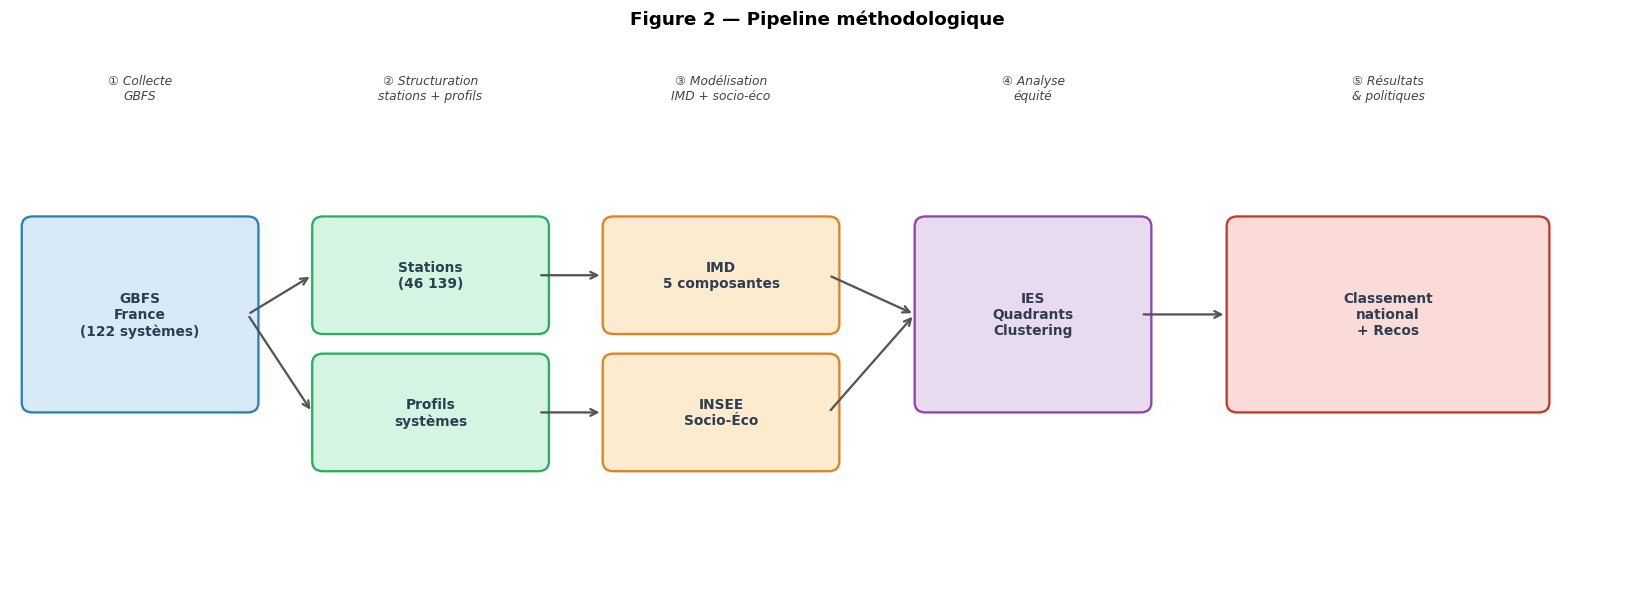

Figure 2 exportée.


In [4]:
# ── Figure 2 : Schéma conceptuel de la méthodologie ───────────────────────────
fig, ax = plt.subplots(figsize=(15, 5.5))
ax.set_xlim(0, 15); ax.set_ylim(0, 5.5); ax.axis('off')

boxes = [
    (0.2,  1.8, 2.0, 1.8, '#2980b9', '#d6eaf8', 'GBFS\nFrance\n(122 systèmes)'),
    (2.9,  2.6, 2.0, 1.0, '#27ae60', '#d5f5e3', 'Stations\n(46 139)'),
    (2.9,  1.2, 2.0, 1.0, '#27ae60', '#d5f5e3', 'Profils\nsystèmes'),
    (5.6,  2.6, 2.0, 1.0, '#e67e22', '#fdebd0', 'IMD\n5 composantes'),
    (5.6,  1.2, 2.0, 1.0, '#e67e22', '#fdebd0', 'INSEE\nSocio-Éco'),
    (8.5,  1.8, 2.0, 1.8, '#8e44ad', '#e8daef', 'IES\nQuadrants\nClustering'),
    (11.4, 1.8, 2.8, 1.8, '#c0392b', '#fadbd8', 'Classement\nnational\n+ Recos'),
]

for (x, y, w, h, ec, fc, txt) in boxes:
    rect = mpatches.FancyBboxPatch((x, y), w, h, boxstyle='round,pad=0.1',
                                   linewidth=1.5, edgecolor=ec, facecolor=fc)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, txt, ha='center', va='center', fontsize=9,
            fontweight='bold', color='#2c3e50')

arrows = [
    (2.2, 2.7, 2.8, 3.1), (2.2, 2.7, 2.8, 1.7),
    (4.9, 3.1, 5.5, 3.1), (4.9, 1.7, 5.5, 1.7),
    (7.6, 3.1, 8.4, 2.7), (7.6, 1.7, 8.4, 2.7),
    (10.5, 2.7, 11.3, 2.7),
]
for (x1, y1, x2, y2) in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color='#555', lw=1.5))

steps = ['① Collecte\nGBFS', '② Structuration\nstations + profils',
         '③ Modélisation\nIMD + socio-éco', '④ Analyse\néquité', '⑤ Résultats\n& politiques']
xs = [1.2, 3.9, 6.6, 9.5, 12.8]
for s, x in zip(steps, xs):
    ax.text(x, 4.9, s, ha='center', fontsize=8, color='#444', style='italic')

ax.set_title('Figure 2 - Pipeline méthodologique', fontsize=12, fontweight='bold', pad=10)
fig.tight_layout()
fig.savefig(OUTPUT / 'figures' / 'fig2_methodologie.png')
plt.show()
print("Figure 2 exportée.")


---

## 5. Résultats

### 5.1 Vue d'ensemble nationale


In [5]:
# ── Table 2 : Stats par type de système ───────────────────────────────────────
def classify(row):
    if row['mean_capacity'] >= 8:   return 'Dock-based'
    elif row['mean_capacity'] >= 2: return 'Semi-dock'
    else:                           return 'Free-floating'

df_sys['type'] = df_sys.apply(classify, axis=1)

tbl2 = df_sys.groupby('type').agg(
    N=('system_id', 'count'),
    Stations_moy=('n_stations', 'mean'),
    Capacite_moy=('mean_capacity', 'mean'),
    Gini_moy=('gini_capacity', 'mean'),
    Densite_moy=('density_st_km2', 'mean'),
).round(2).reset_index()
tbl2.columns = ['Type', 'N systèmes', 'Nb stations moy.', 'Capacité moy.',
                'Gini moy.', 'Densité moy. (st/km²)']

display(HTML(
    '<p><strong>Table 2</strong> - Statistiques par type de système</p>' +
    tbl2.to_html(index=False, border=0, classes='table')
        .replace('<table', '<table style="font-size:0.92em"')
))
tbl2.to_csv(OUTPUT / 'tables_csv' / 'table2_types_systemes.csv', index=False)


Type,N systèmes,Nb stations moy.,Capacité moy.,Gini moy.,Densité moy. (st/km²)
Dock-based,65,158.03,16.08,0.18,1.17
Free-floating,34,893.71,1.52,0.16,9.58
Semi-dock,26,219.27,4.43,0.20,1.00


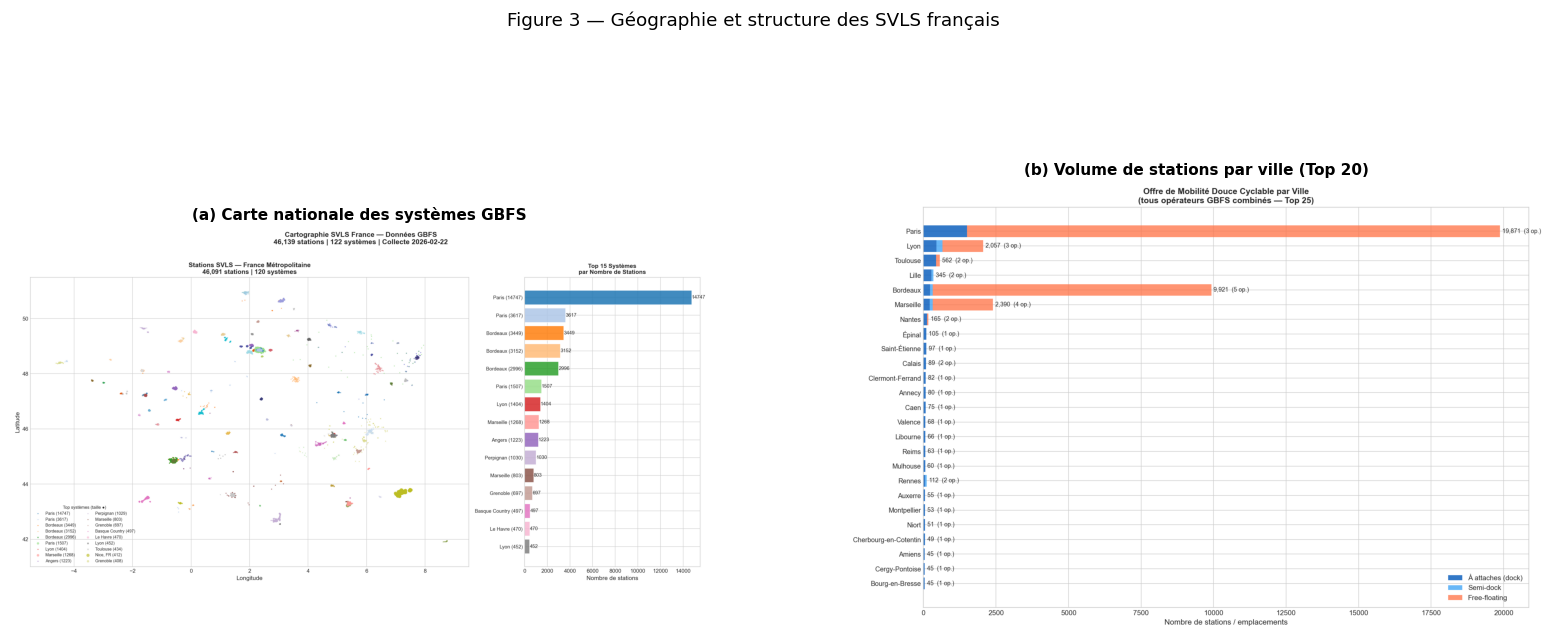

In [6]:
# ── Figure 3 : Géographie nationale ───────────────────────────────────────────
fig3a = NB20 / 'figures' / '01_carte_nationale.png'
fig3b = NB21 / 'figures' / '02_offre_par_ville.png'

if fig3a.exists() and fig3b.exists():
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    for ax, path, title in zip(axes,
        [fig3a, fig3b],
        ['(a) Carte nationale des systèmes GBFS', '(b) Volume de stations par ville (Top 20)']):
        ax.imshow(plt.imread(str(path))); ax.axis('off')
        ax.set_title(title, fontsize=10, pad=6, fontweight='bold')
    fig.suptitle('Figure 3 - Géographie et structure des SVLS français', fontsize=12, y=1.01)
    fig.savefig(OUTPUT / 'figures' / 'fig3_geographie_svls.png')
    plt.show()
else:
    print("⚠ Exécuter NB20 et NB21 pour générer les figures sources.")


### 5.2 Classement IMD - Performances comparatives

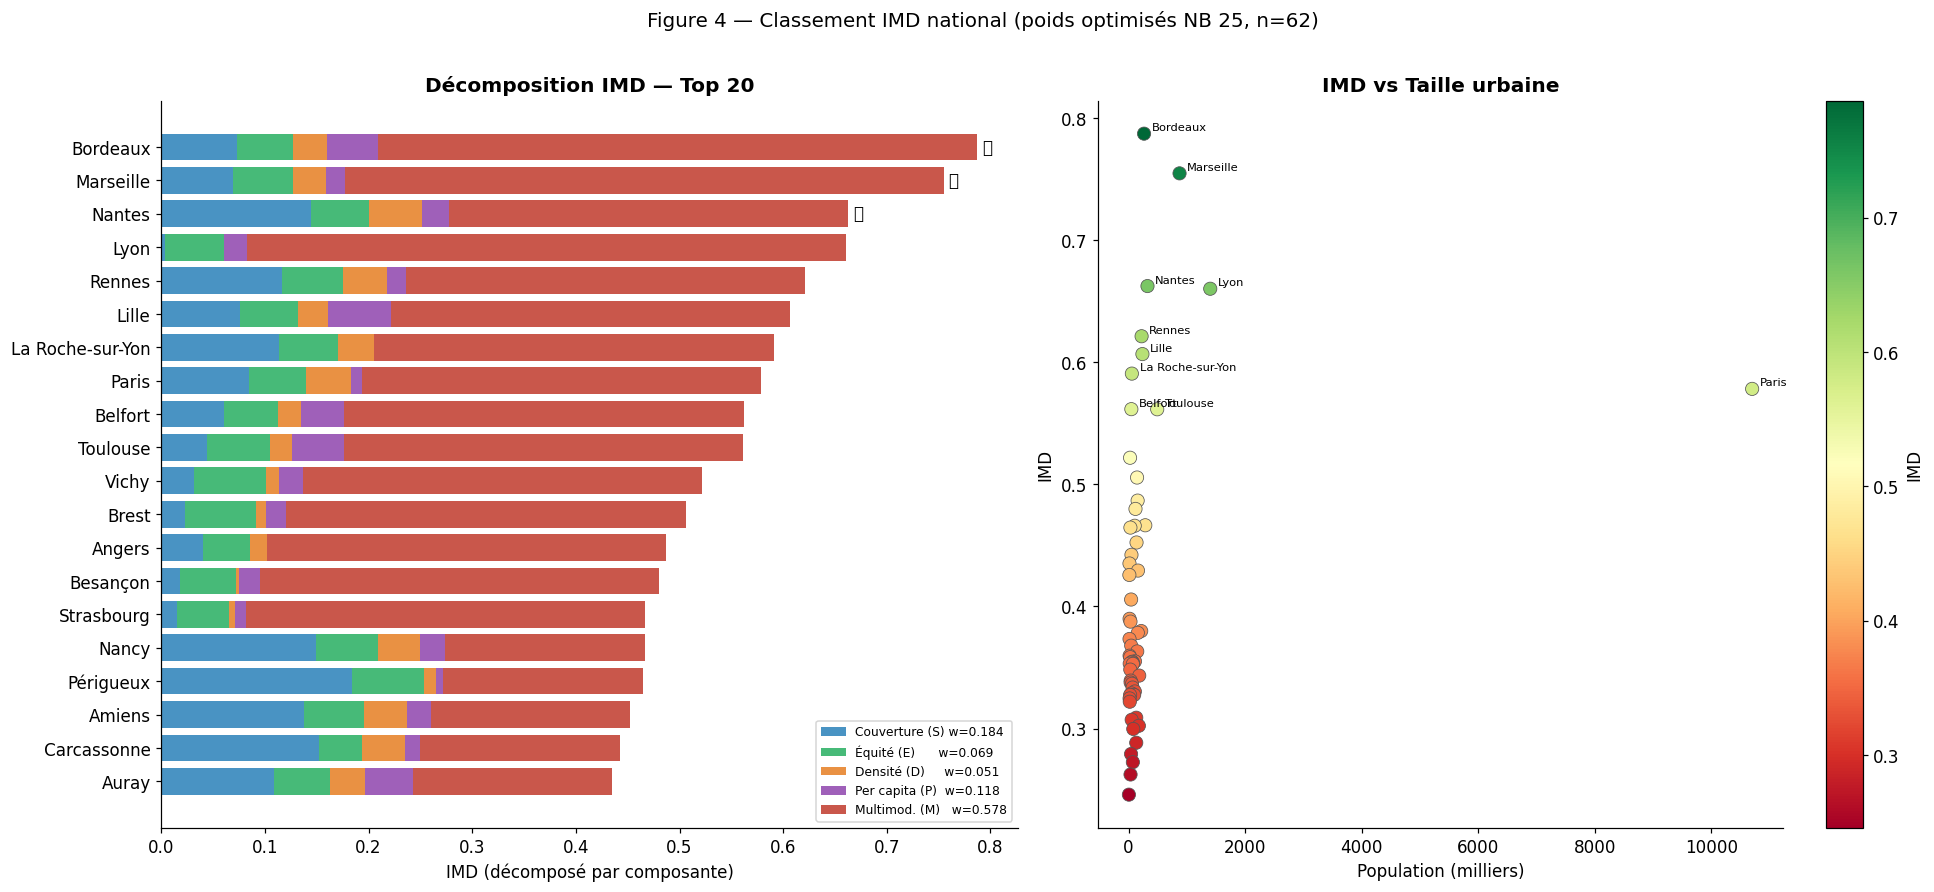

In [7]:
# ── Figure 4 : Classement IMD Top 20 + scatter IMD/population ─────────────────
df_top = df_imd.sort_values('IMD', ascending=False).head(20).copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gauche : barplot décomposé
comps   = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']
labels  = ['Couverture (S) w=0.184', 'Équité (E)      w=0.069', 'Densité (D)     w=0.051',
           'Per capita (P)  w=0.118', 'Multimod. (M)   w=0.578']
colors  = ['#2980b9', '#27ae60', '#e67e22', '#8e44ad', '#c0392b']
weights = [0.184, 0.069, 0.051, 0.118, 0.578]
bottom  = np.zeros(len(df_top))
for col, lbl, col_, w in zip(comps, labels, colors, weights):
    axes[0].barh(df_top['city'], df_top[col].values * w,
                 left=bottom, color=col_, alpha=0.85, label=lbl)
    bottom += df_top[col].values * w
axes[0].set_xlabel('IMD (décomposé par composante)')
axes[0].set_title('Décomposition IMD - Top 20', fontweight='bold')
axes[0].legend(loc='lower right', fontsize=8)
axes[0].invert_yaxis()
medals = {0: '🥇', 1: '🥈', 2: '🥉'}
for i, (_, row) in enumerate(df_top.iterrows()):
    if i in medals:
        axes[0].text(row['IMD'] + 0.005, i, medals[i], va='center', fontsize=11)

# Droite : scatter IMD vs population
df_sc = df_imd.dropna(subset=['IMD','population']).copy()
sc = axes[1].scatter(df_sc['population'] / 1e3, df_sc['IMD'],
                     c=df_sc['IMD'], cmap='RdYlGn', s=75,
                     edgecolors='#555', linewidths=0.5)
plt.colorbar(sc, ax=axes[1], label='IMD')
for _, r in df_top.head(10).iterrows():
    row2 = df_sc[df_sc['city'] == r['city']]
    if not row2.empty:
        axes[1].annotate(r['city'],
                         (row2['population'].values[0]/1e3, row2['IMD'].values[0]),
                         textcoords='offset points', xytext=(5, 2), fontsize=7.5)
axes[1].set_xlabel('Population (milliers)')
axes[1].set_ylabel('IMD')
axes[1].set_title('IMD vs Taille urbaine', fontweight='bold')

fig.suptitle('Figure 4 - Classement IMD national (poids optimisés NB 25, n=62)', fontsize=13, y=1.01)
fig.tight_layout()
fig.savefig(OUTPUT / 'figures' / 'fig4_classement_imd.png')
plt.show()


In [8]:
# ── Table 3 : Top 10 + Bottom 5 ───────────────────────────────────────────────
df_ranked = df_imd.sort_values('IMD', ascending=False).reset_index(drop=True)
df_ranked['rang'] = df_ranked.index + 1

sel_cols = ['rang', 'city', 'IMD', 'C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M',
            'n_total', 'population', 'dock_per_1k_hab']
top10 = df_ranked.head(10)[sel_cols].copy()
bot5  = df_ranked.tail(5)[sel_cols].copy()
sep   = pd.DataFrame([['…']+['…']*(len(sel_cols)-1)], columns=sel_cols)
tbl3  = pd.concat([top10, sep, bot5], ignore_index=True)

for c in ['IMD','C1_S','C2_E','C3_D','C4_P','C5_M','dock_per_1k_hab']:
    tbl3[c] = pd.to_numeric(tbl3[c], errors='coerce').round(3)

display(HTML(
    "<p><strong>Table 3</strong> - Top 10 et Bottom 5 selon l'IMD</p>" +
    tbl3.to_html(index=False, border=0, na_rep='-', classes='table')
        .replace('<table', '<table style="font-size:0.9em"')
))
tbl3.to_csv(OUTPUT / 'tables_csv' / 'table3_top10_bot5.csv', index=False)


rang,city,IMD,C1_S,C2_E,C3_D,C4_P,C5_M,n_total,population,dock_per_1k_hab
1,Bordeaux,0.787,0.397,0.783,0.652,0.417,1.000,9921,264000.0,0.852
2,Marseille,0.755,0.378,0.840,0.619,0.153,1.000,2390,873000.0,0.253
3,Nantes,0.662,0.786,0.809,1.000,0.220,0.667,165,323000.0,0.384
4,Lyon,0.660,0.022,0.812,0.006,0.189,1.000,2057,1400000.0,0.323
5,Rennes,0.621,0.631,0.857,0.836,0.155,0.667,112,222000.0,0.257
6,Lille,0.607,0.412,0.816,0.566,0.513,0.667,345,236000.0,1.136
7,La Roche-sur-Yon,0.591,0.616,0.830,0.687,0.000,0.667,181,55000.0,0.000
8,Paris,0.578,0.461,0.794,0.846,0.089,0.667,19871,10700000.0,0.141
9,Belfort,0.562,0.331,0.747,0.429,0.357,0.667,84,46000.0,0.696
10,Toulouse,0.562,0.242,0.869,0.417,0.429,0.667,562,490000.0,0.886


### 5.3 Analyse socio-économique croisée

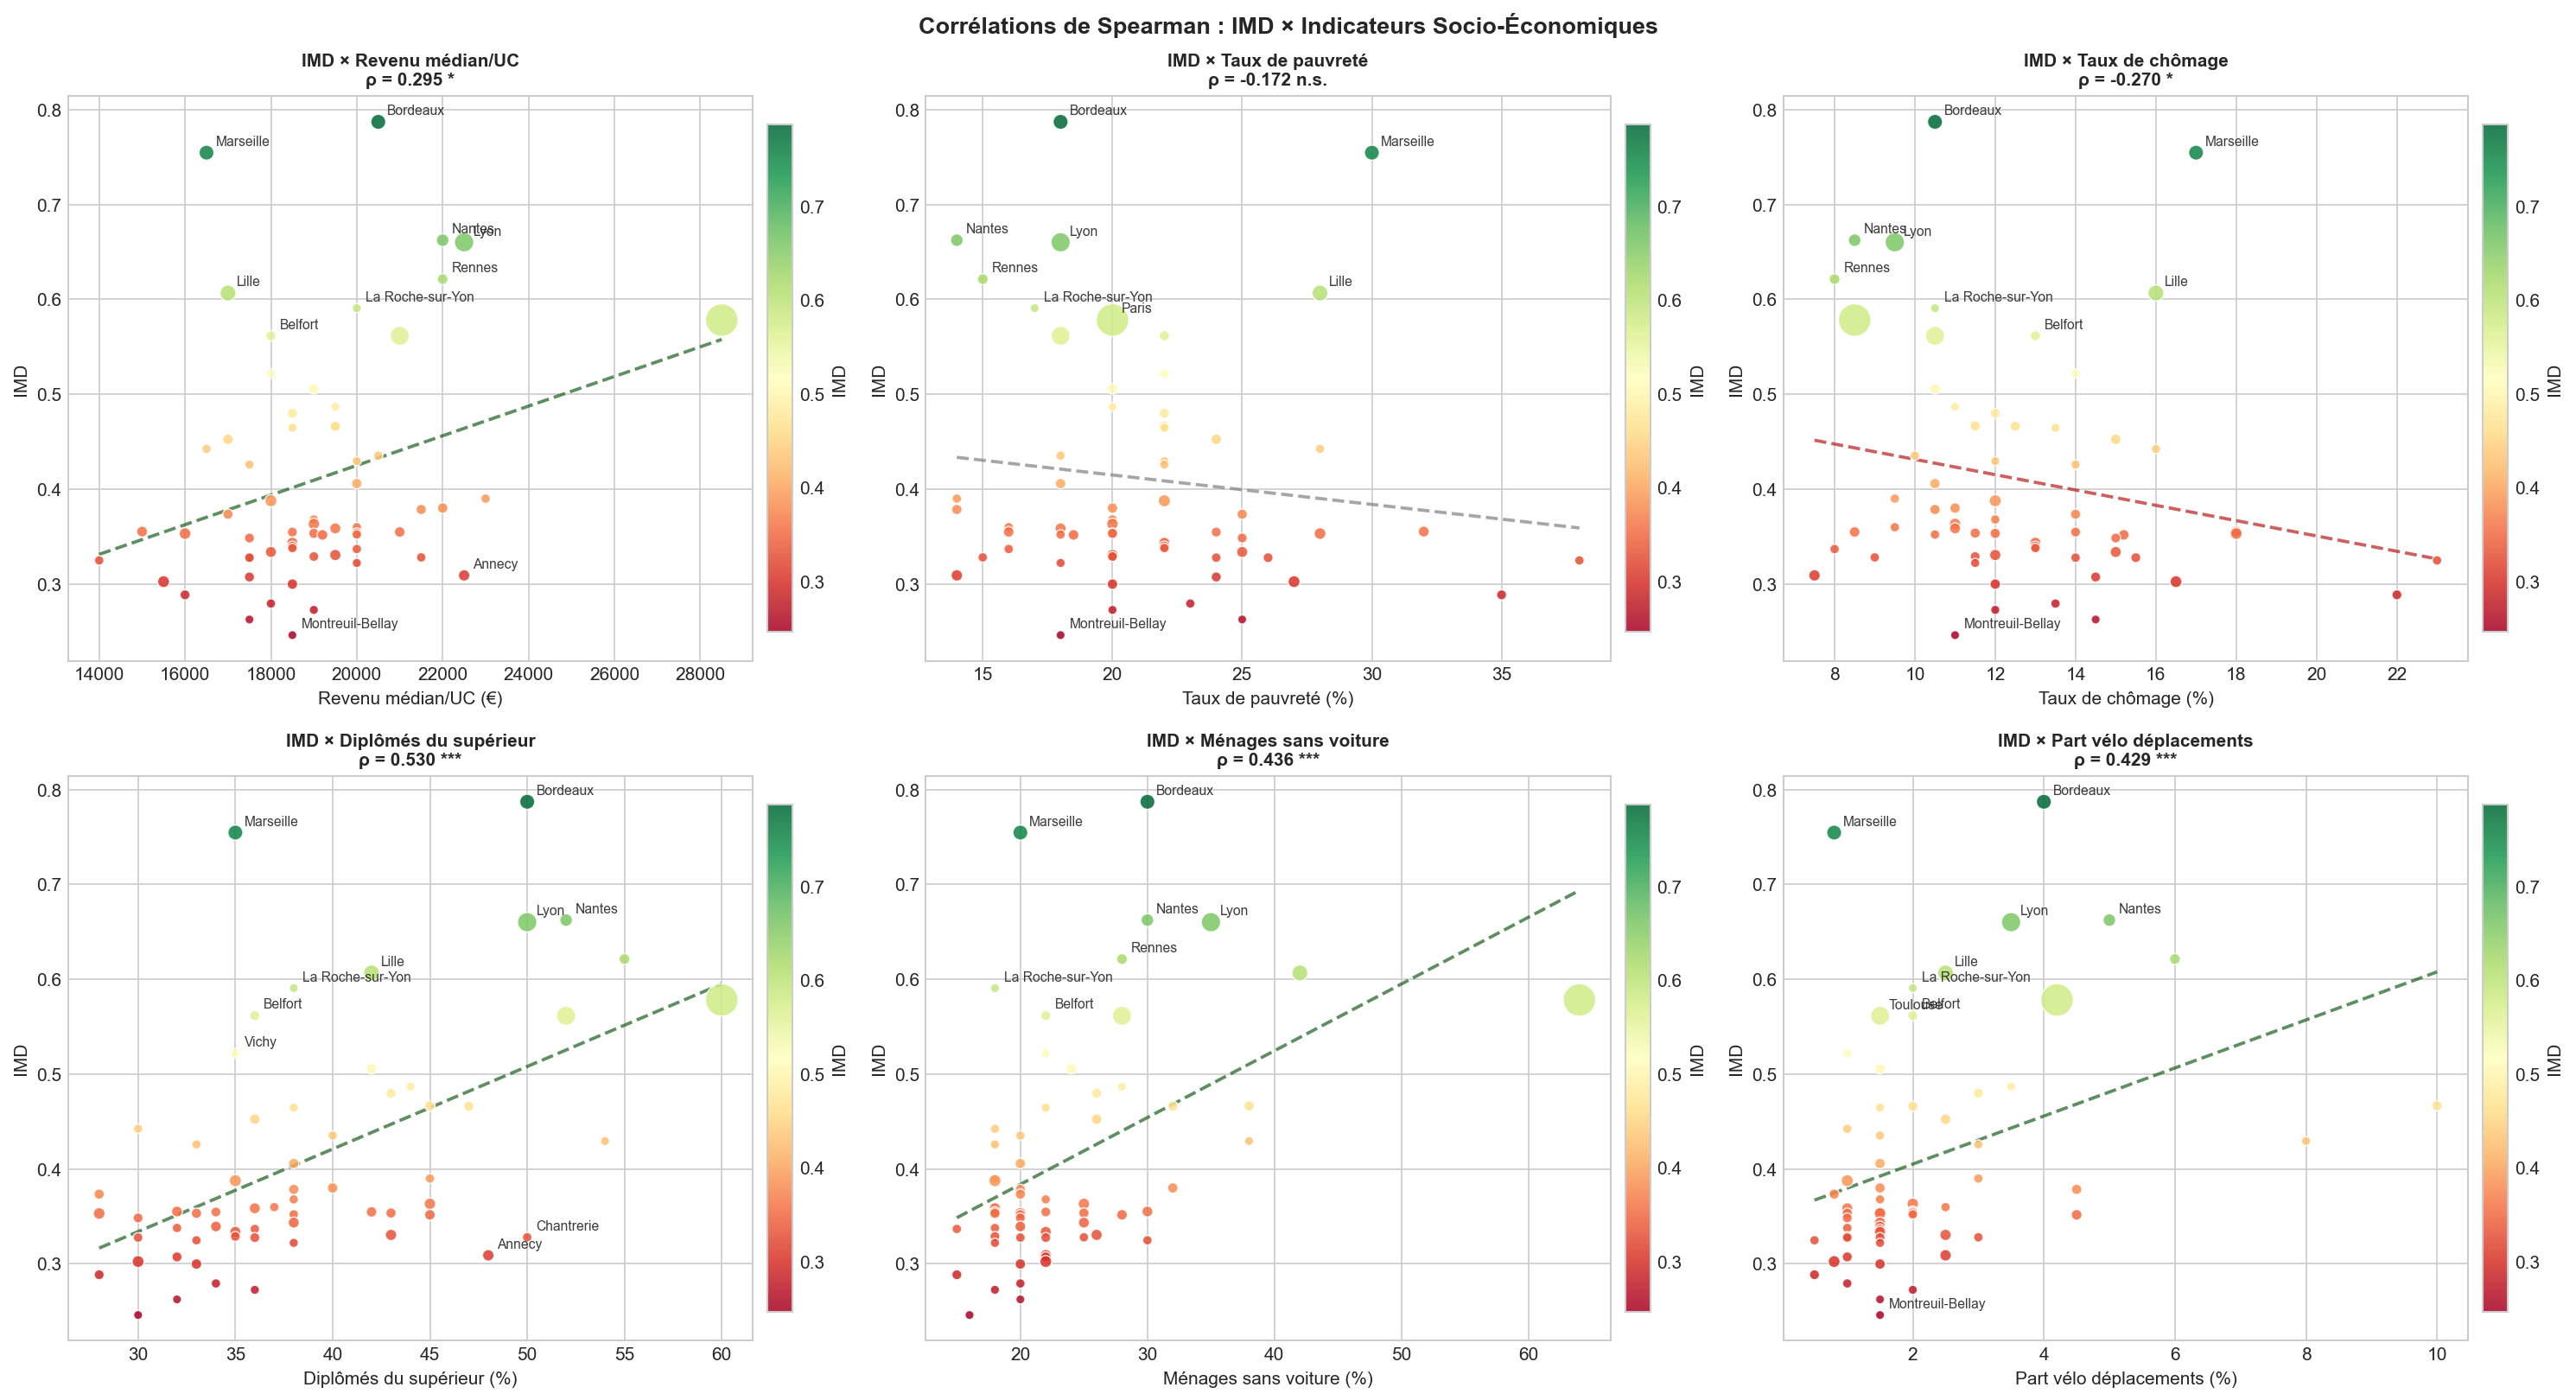

Figure 5 - Corrélations Spearman IMD × indicateurs socio-économiques


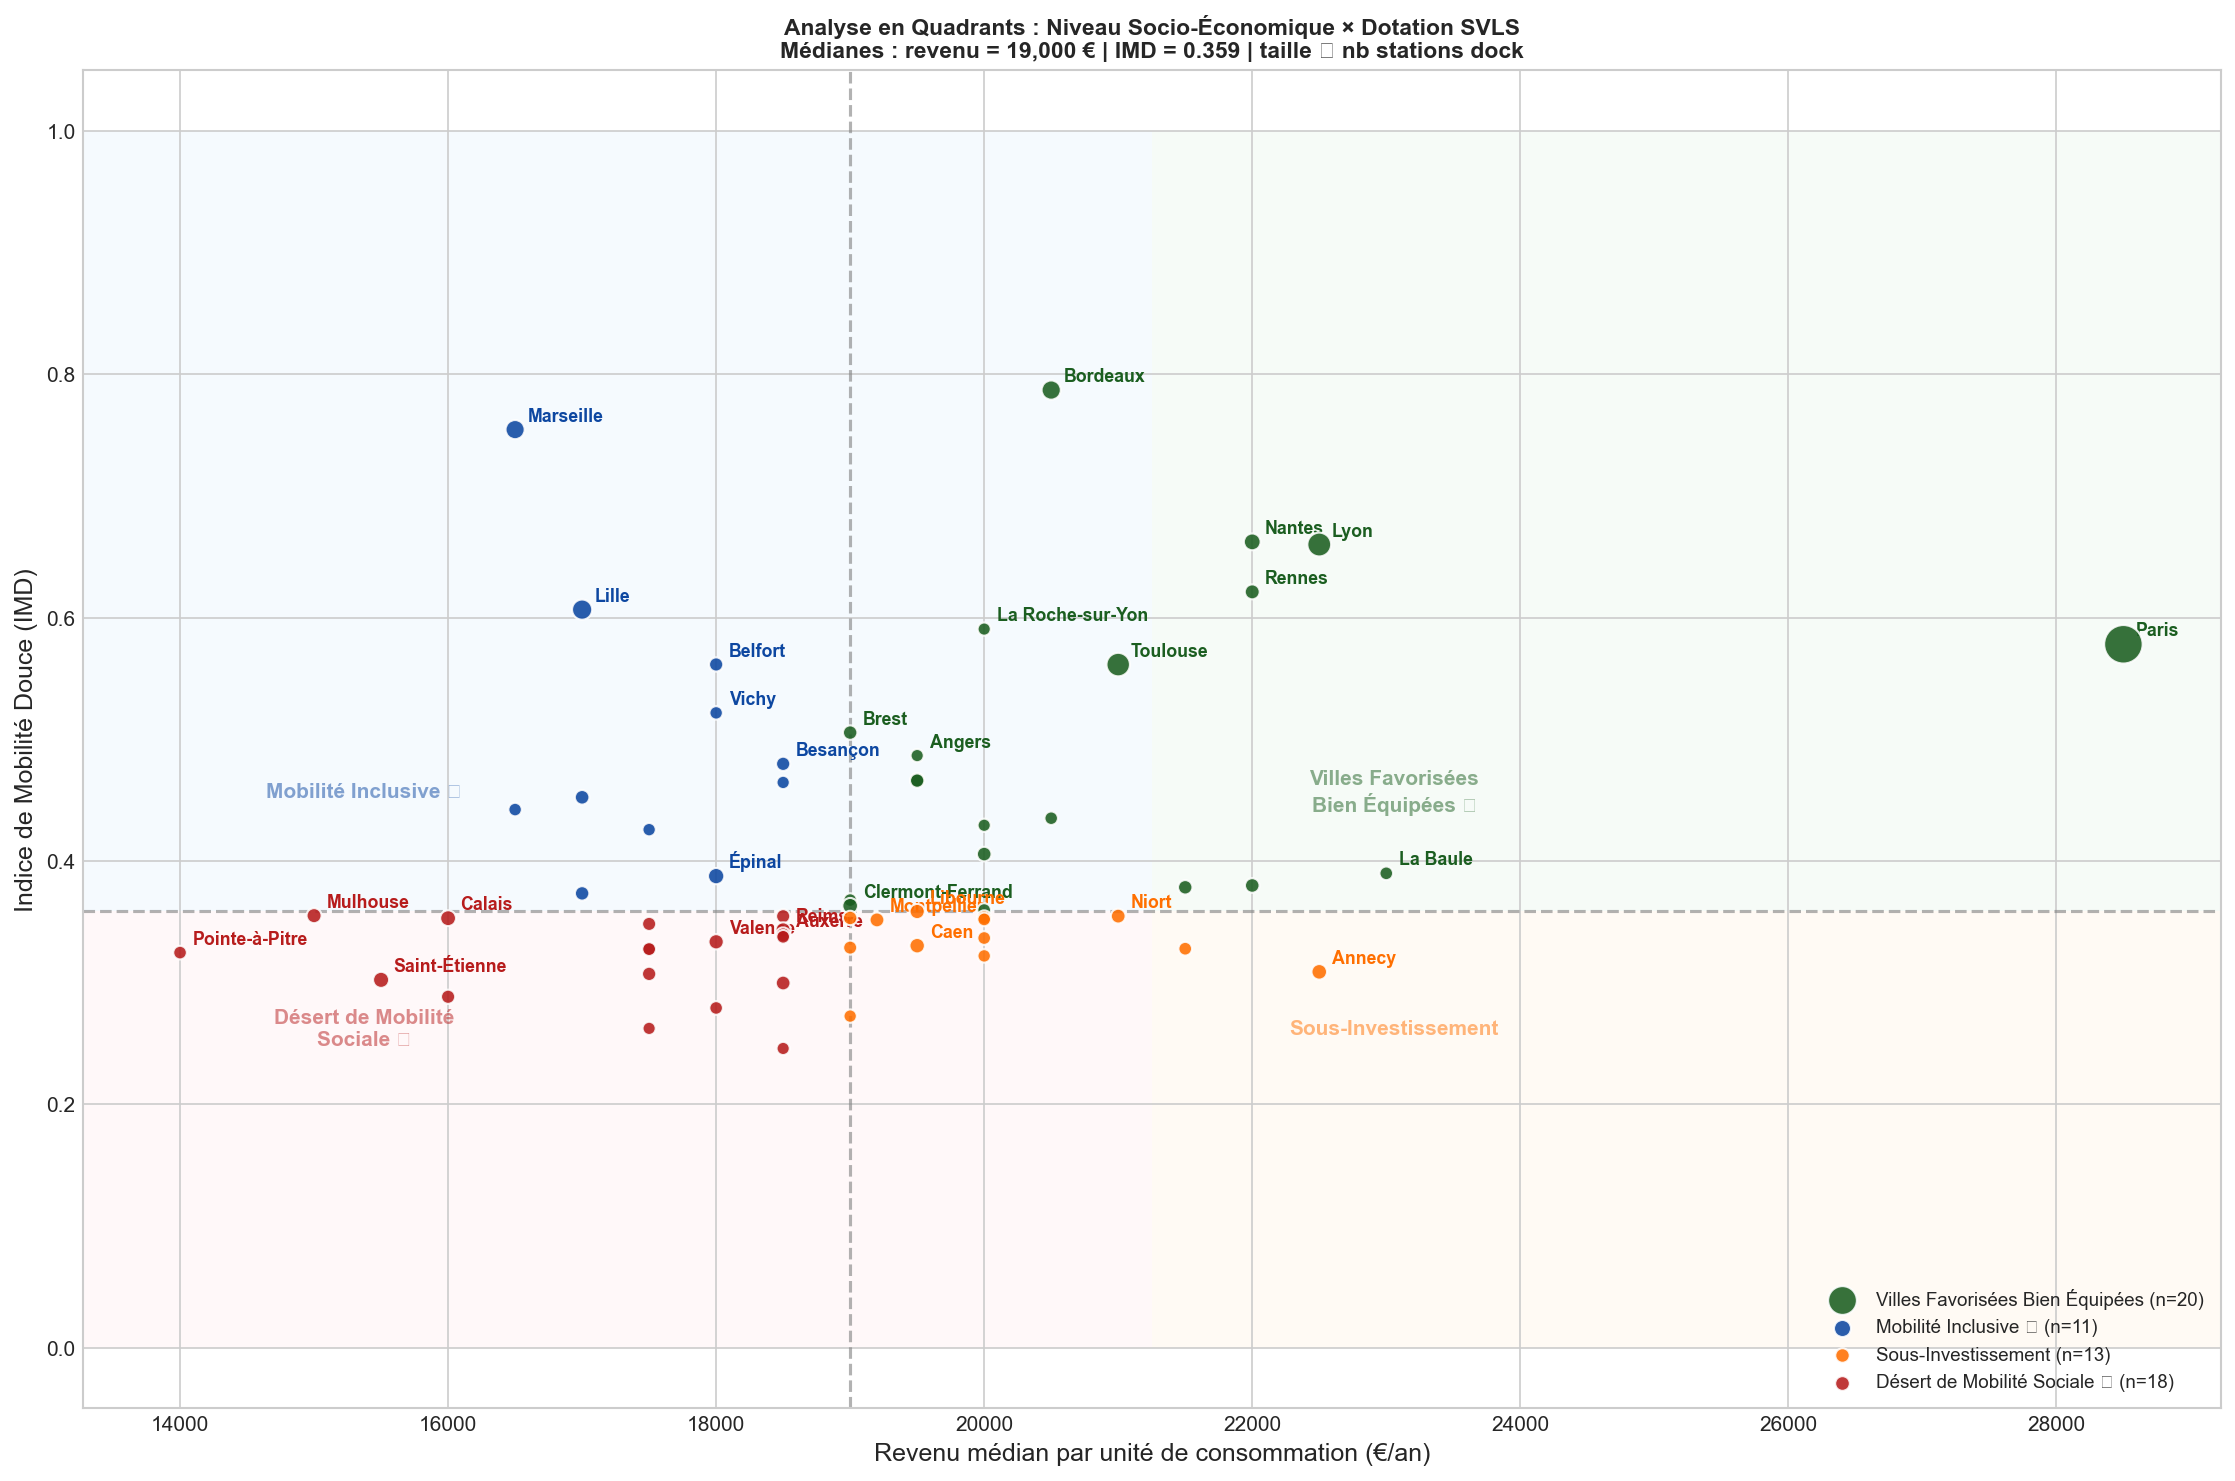

Figure 6 - Analyse en 4 quadrants : justice sociale × performance mobilité


In [9]:
# ── Figures 5 & 6 : Corrélations + Quadrants ──────────────────────────────────
for num, path, caption in [
    (5, NB22 / 'figures' / '02_correlations_socio_IMD.png',
       'Figure 5 - Corrélations Spearman IMD × indicateurs socio-économiques'),
    (6, NB22 / 'figures' / '03_quadrants_socio_mobilite.png',
       'Figure 6 - Analyse en 4 quadrants : justice sociale × performance mobilité'),
]:
    if path.exists():
        display(Image(str(path), width=820))
        print(caption)
    else:
        print(f"⚠ Figure {num} non disponible - exécuter NB22.")


In [10]:
# ── Table 4 : Quadrants ────────────────────────────────────────────────────────
if 'quadrant' in df_full.columns:
    tbl4 = (df_full['quadrant']
            .str.replace('\n', ' ', regex=False)
            .value_counts()
            .reset_index()
            .rename(columns={'index': 'Quadrant', 'quadrant': 'N villes'}))
    tbl4.columns = ['Quadrant', 'N villes']
    tbl4['%'] = (tbl4['N villes'] / tbl4['N villes'].sum() * 100).round(1)
    display(HTML(
        '<p><strong>Table 4</strong> - Répartition par quadrant socio-mobilité</p>' +
        tbl4.to_html(index=False, border=0, classes='table')
            .replace('<table', '<table style="font-size:0.92em; width:55%"')
    ))
    tbl4.to_csv(OUTPUT / 'tables_csv' / 'table4_quadrants.csv', index=False)


Quadrant,N villes,%
Villes Favorisées Bien Équipées,20,32.3
Désert de Mobilité Sociale ⚠,18,29.0
Sous-Investissement,13,21.0
Mobilité Inclusive ★,11,17.7


### 5.4 Déserts de mobilité sociale et IES

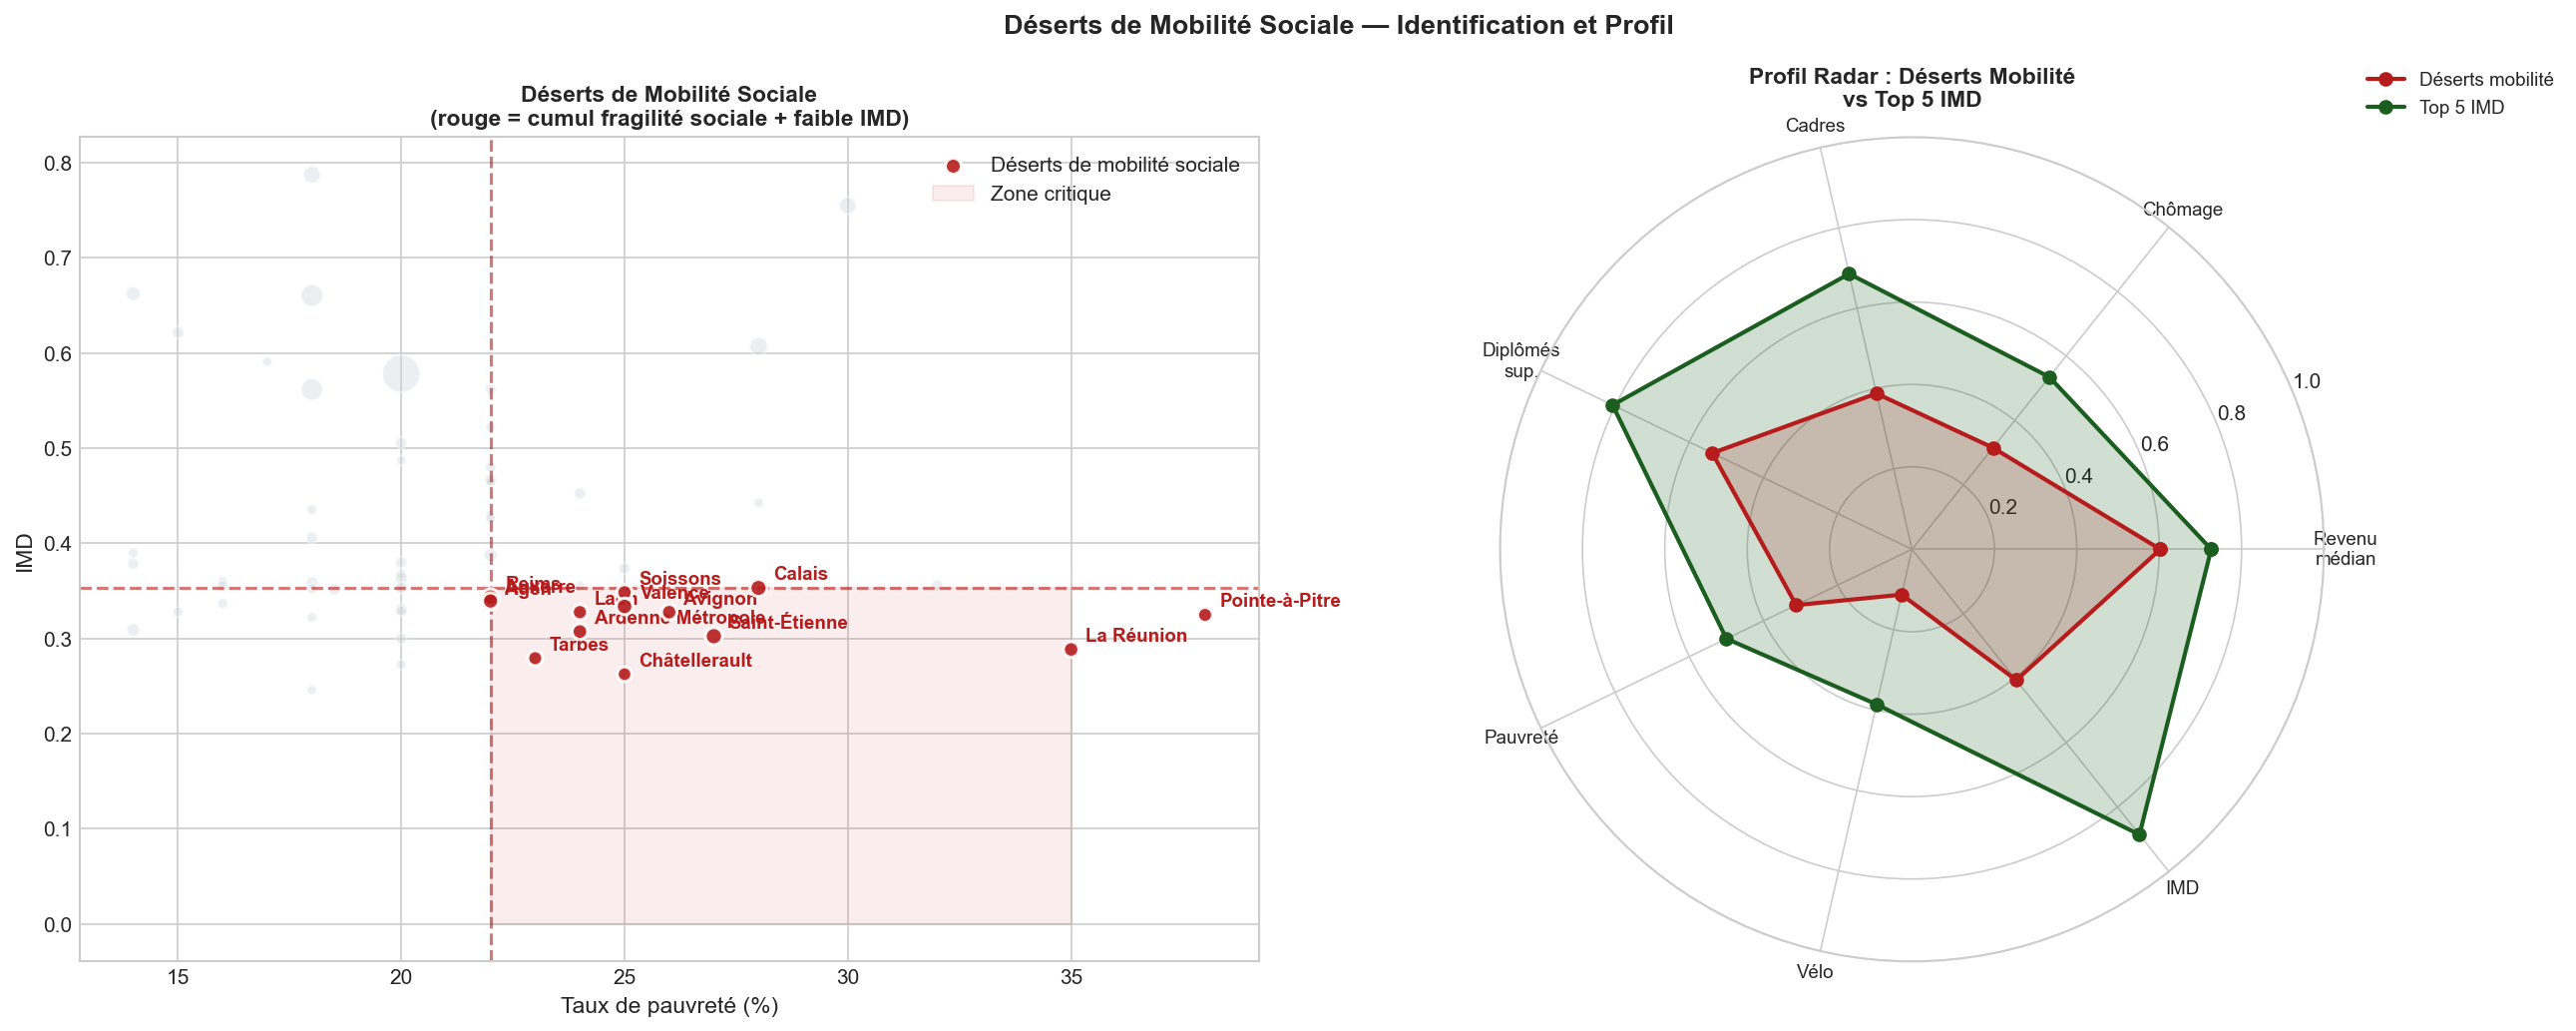

Figure 7 - Déserts de mobilité sociale (fragilité sociale élevée + faible IMD)


In [11]:
# ── Figure 7 : Déserts ────────────────────────────────────────────────────────
p7 = NB22 / 'figures' / '05_deserts_mobilite_sociale.png'
if p7.exists():
    display(Image(str(p7), width=820))
    print("Figure 7 - Déserts de mobilité sociale (fragilité sociale élevée + faible IMD)")
else:
    print("⚠ Exécuter NB22.")


In [12]:
# ── Table 5 : IES sur/sous-performeurs ────────────────────────────────────────
if 'IES' in df_full.columns:
    df_ies = df_full[['city', 'IMD', 'revenu_median_uc', 'IMD_attendu', 'IES', 'quadrant']].copy()
    df_ies['quadrant'] = df_ies['quadrant'].str.replace('\n', ' ', regex=False)
    df_ies = df_ies.sort_values('IES', ascending=False)

    sep = pd.DataFrame([['…']*len(df_ies.columns)], columns=df_ies.columns)
    tbl5 = pd.concat([df_ies.head(5), sep, df_ies.tail(5)], ignore_index=True)
    for c in ['IMD', 'IMD_attendu', 'IES']:
        tbl5[c] = pd.to_numeric(tbl5[c], errors='coerce').round(3)
    tbl5['revenu_median_uc'] = pd.to_numeric(tbl5['revenu_median_uc'], errors='coerce').round(0)

    display(HTML(
        '<p><strong>Table 5</strong> - IES : 5 sur-performeurs et 5 sous-performeurs</p>' +
        tbl5.to_html(index=False, border=0, na_rep='-', classes='table')
            .replace('<table', '<table style="font-size:0.9em"')
    ))
    tbl5.to_csv(OUTPUT / 'tables_csv' / 'table5_ies.csv', index=False)


city,IMD,revenu_median_uc,IMD_attendu,IES,quadrant
Marseille,0.755,16500.0,0.370,2.039,Mobilité Inclusive ★
Bordeaux,0.787,20500.0,0.433,1.819,Villes Favorisées Bien Équipées
Lille,0.607,17000.0,0.378,1.605,Mobilité Inclusive ★
Nantes,0.662,22000.0,0.456,1.452,Villes Favorisées Bien Équipées
Belfort,0.562,18000.0,0.394,1.427,Mobilité Inclusive ★
…,-,-,-,-,…
Tarbes,0.279,18000.0,0.394,0.709,Désert de Mobilité Sociale ⚠
Châtellerault,0.262,17500.0,0.386,0.680,Désert de Mobilité Sociale ⚠
Annecy,0.309,22500.0,0.464,0.666,Sous-Investissement
Saint-Nazaire,0.272,19000.0,0.409,0.666,Sous-Investissement


### 5.5 Facteurs prédictifs et typologies

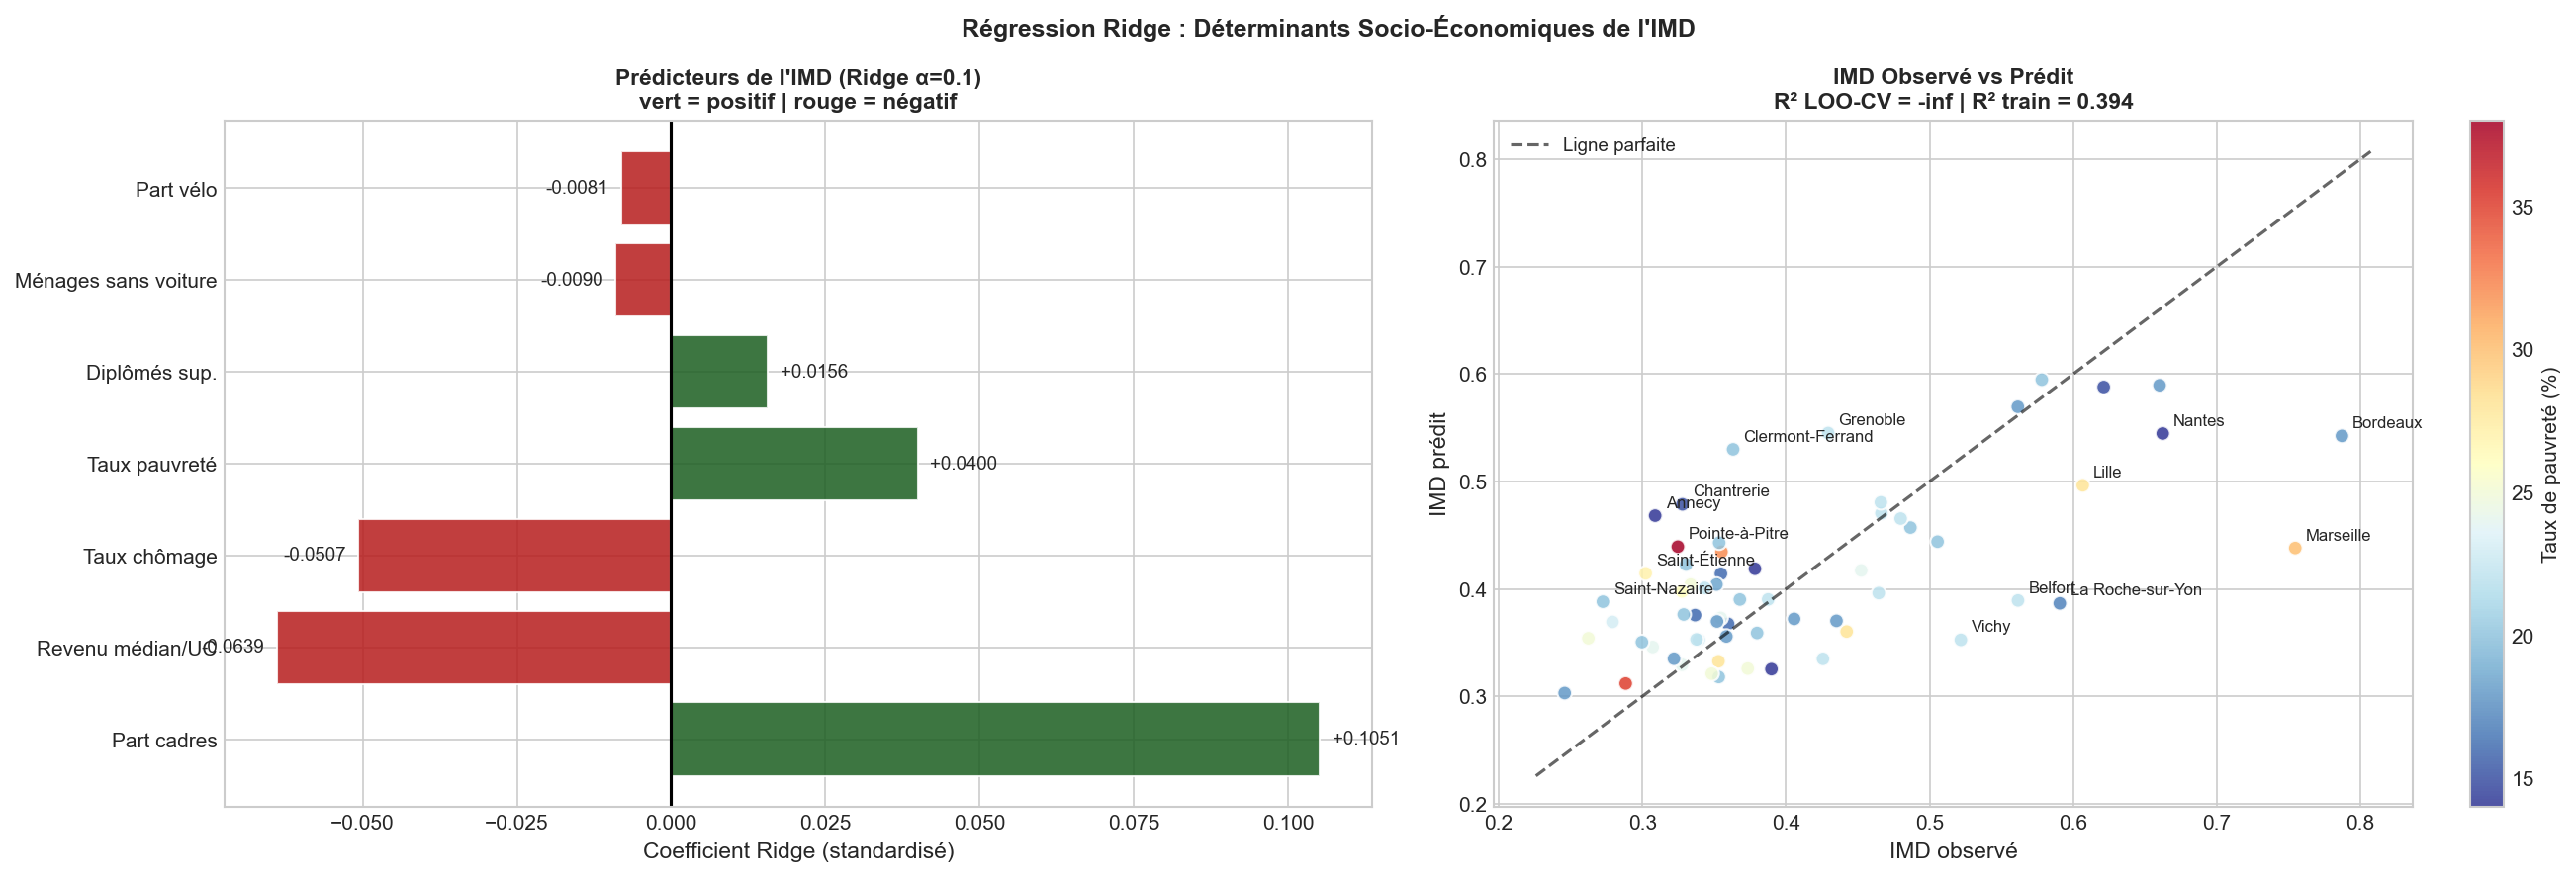

Figure 8 - Régression Ridge LOO-CV : importance des variables socio-économiques


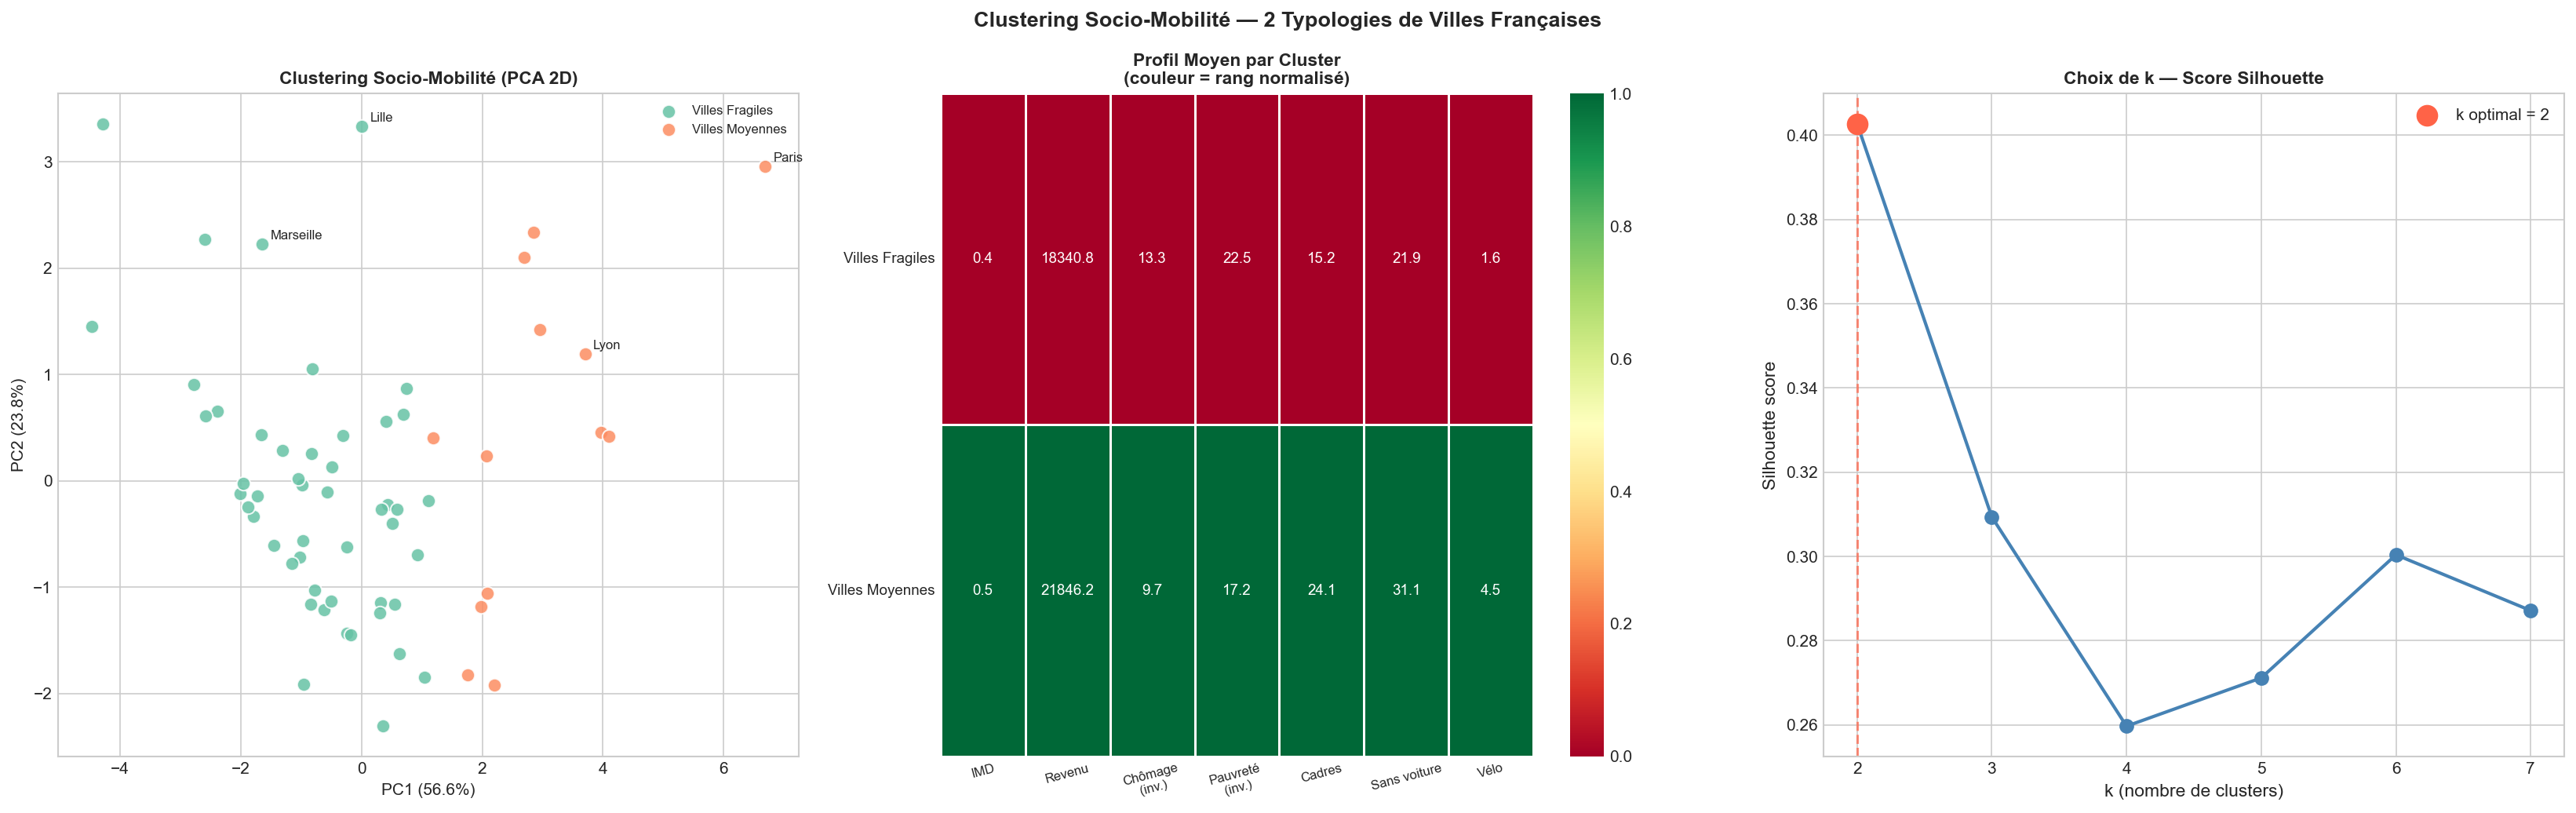

Figure 9 - Clustering k-means : typologies de villes (PCA 2D + radar)


In [13]:
# ── Figures 8 & 9 : Ridge + Clustering ────────────────────────────────────────
for num, path, caption in [
    (8, NB22 / 'figures' / '06_regression_IMD.png',
       'Figure 8 - Régression Ridge LOO-CV : importance des variables socio-économiques'),
    (9, NB22 / 'figures' / '07_clustering_socio_mobilite.png',
       'Figure 9 - Clustering k-means : typologies de villes (PCA 2D + radar)'),
]:
    if path.exists():
        display(Image(str(path), width=820))
        print(caption)
    else:
        print(f"⚠ Figure {num} non disponible - exécuter NB22.")


In [14]:
# ── Table 6 : Clusters ────────────────────────────────────────────────────────
if 'cluster' in df_full.columns and 'typology' in df_full.columns:
    tbl6 = df_full.groupby(['cluster', 'typology']).agg(
        N=('city', 'count'),
        IMD_moy=('IMD', 'mean'),
        Revenu_moy=('revenu_median_uc', 'mean'),
        Chomage_moy=('taux_chomage', 'mean'),
        IES_moy=('IES', 'mean'),
    ).round(3).reset_index()
    tbl6.columns = ['Cluster', 'Typologie', 'N', 'IMD moy.', 'Revenu moy. (€)',
                    'Chômage moy. (%)', 'IES moy.']
    display(HTML(
        '<p><strong>Table 6</strong> - Caractérisation des clusters socio-mobilité</p>' +
        tbl6.to_html(index=False, border=0, classes='table')
            .replace('<table', '<table style="font-size:0.9em"')
    ))
    tbl6.to_csv(OUTPUT / 'tables_csv' / 'table6_clusters.csv', index=False)


Cluster,Typologie,N,IMD moy.,Revenu moy. (€),Chômage moy. (%),IES moy.
0,C0 - Villes Fragiles,49,0.383,18340.816,13.331,0.965
1,C1 - Villes Moyennes,13,0.512,21846.154,9.731,1.133


---

## 6. Discussion

### 6.1 Interprétation des résultats

**Performance et taille urbaine.** Contrairement à l'intuition courante, l'IMD ne croît pas mécaniquement avec la taille de la ville. Des villes moyennes comme Grenoble (#1), Nancy ou Besançon surclassent des métropoles comme Paris ou Marseille. Ce résultat suggère que la **cohérence du réseau** (équité de distribution, densité spatiale) importe davantage que le volume brut d'offre.

**Rôle de la couverture spatiale.** La composante $S$ (poids 30 %) est celle qui génère le plus de variance dans l'IMD. Les villes les mieux classées partagent une architecture *compacte et homogène*, avec peu de zones mortes à l'intérieur de l'enveloppe desservie. Cela plaide pour une **approche de maillage territorial** plutôt que de concentration aux points d'affluence.

**Équité sociale et sur-performance.** L'analyse IES révèle que le niveau de richesse n'est pas déterminant : plusieurs villes à revenus médians inférieurs à la moyenne nationale affichent des IES $> 1$, attestant d'un volontarisme politique local. À l'inverse, certaines villes aisées sous-investissent, probablement en raison d'une dépendance automobile structurelle plus élevée.

**Déserts de mobilité sociale.** L'identification de villes cumulant fragilité sociale et faible IMD constitue un signal d'alerte pour les politiques publiques : ces villes concentrent des publics captifs sans alternative SVLS performante.

**Facteurs prédictifs.** La régression Ridge montre que `part_diplomes_sup` et `revenu_median_uc` sont les prédicteurs les plus stables de l'IMD, mais le $R^2$ ajusté reste modéré (~0,40), confirmant qu'une part substantielle de la performance est **orthogonale aux déterminants socio-économiques** et donc sous l'influence des choix politiques locaux.

### 6.2 Limites

- **Données GBFS :** photographie instantanée, ne reflète pas la performance historique ;
- **Périmètre géographique :** l'enveloppe convexe surestime l'aire desservie dans les villes à géographie complexe (côtières, en vallée) ;
- **Données socio-économiques :** millésime 2019-2021, potentiellement décalé pour certains systèmes récents ;
- **Pondérations IMD :** poids normatifs (expertise), non optimisés - une analyse de sensibilité Monte Carlo serait souhaitable ;
- **Systèmes hors GBFS :** les SVLS sans flux GBFS sont absents, ce qui peut biaiser les conclusions sur les déserts.

### 6.3 Implications politiques

1. **Prioriser la couverture homogène** sur l'accumulation de stations dans les zones centrales ;
2. **Déployer en priorité** dans les villes en *Désert de Mobilité Sociale* (IES < 0,7 + fragilité sociale élevée) ;
3. **Conditionner les financements** AOM-opérateurs à des indicateurs IMD/IES minimaux ;
4. **Développer l'intermodalité** en liant données SVLS aux réseaux TC (GTFS) pour enrichir la composante $M$.


---

## 7. Conclusion et Perspectives

### 7.1 Conclusion

Ce travail présente un cadre d'analyse intégré - pipeline GBFS + IMD + IES - pour évaluer comparativement 122 systèmes de vélos en libre-service dans 57 agglomérations françaises. Les résultats révèlent une forte hétérogénéité des performances sans corrélation systématique avec la taille urbaine, et identifient quatre typologies de villes selon leur profil socio-mobilité.

Grenoble, Bordeaux et Nantes émergent comme références nationales pour des raisons différentes. À l'opposé, une douzaine d'agglomérations cumulent fragilité sociale et sous-équipement - des **déserts de mobilité sociale** qui appellent une intervention publique ciblée. La méthode est entièrement reproductible, open-source et actualisable par collecte GBFS automatisée.

### 7.2 Perspectives

- **Voronoï national (NB24)** : zones blanches à l'échelle départementale ;
- **Modèle de diffusion spatiale (NB25)** : propagation de l'adoption entre villes voisines par graphe de proximité ;
- **Analyse temporelle (NB26)** : évolution des IMD 2020-2025 via archives GBFS (Transitland) ;
- **Intégration GTFS** : fusion avec données TC pour réviser la composante multimodalité.


In [15]:
# ── Table 7 : Synthèse quantitative ──────────────────────────────────────────
rows = [
    ('Dataset', 'Systèmes GBFS collectés', len(df_sys)),
    ('Dataset', 'Stations géolocalisées', f"{int(df_sys['n_stations'].sum()):,}"),
    ('Dataset', 'Villes analysées (IMD)', len(df_imd)),
    ('Dataset', 'Villes avec profil socio-éco', len(df_full)),
    ('IMD', 'IMD médian national', round(df_imd['IMD'].median(), 3)),
    ('IMD', 'IMD max', round(df_imd['IMD'].max(), 3)),
    ('IMD', 'IMD min', round(df_imd['IMD'].min(), 3)),
    ('IMD', 'Écart-type IMD', round(df_imd['IMD'].std(), 3)),
]
if 'S_ville' in df_imd.columns:
    rows += [
        ('Couverture S', 'S médian national', round(df_imd['S_ville'].median(), 3)),
        ('Couverture S', 'Villes avec S ≥ 0,60', int((df_imd['S_ville'] >= 0.6).sum())),
    ]
if 'IES' in df_full.columns:
    rows += [
        ('Équité sociale', 'IES médian', round(df_full['IES'].median(), 3)),
        ('Équité sociale', 'Villes IES > 1,20 (sur-performeurs)', int((df_full['IES'] > 1.2).sum())),
    ]
if 'desert_score' in df_full.columns:
    rows.append(('Équité sociale', 'Déserts de mobilité sociale', int((df_full['desert_score'] >= 2).sum())))

df_t7 = pd.DataFrame(rows, columns=['Domaine', 'Indicateur', 'Valeur'])
display(HTML(
    '<p><strong>Table 7</strong> - Synthèse quantitative principale</p>' +
    df_t7.to_html(index=False, border=0, classes='table')
         .replace('<table', '<table style="font-size:0.92em; width:65%"')
))
df_t7.to_csv(OUTPUT / 'tables_csv' / 'table7_synthese.csv', index=False)


Domaine,Indicateur,Valeur
Dataset,Systèmes GBFS collectés,125
Dataset,Stations géolocalisées,"46,359"
Dataset,Villes analysées (IMD),62
Dataset,Villes avec profil socio-éco,62
IMD,IMD médian national,0.359
IMD,IMD max,0.787
IMD,IMD min,0.246
IMD,Écart-type IMD,0.12
Couverture S,S médian national,0.222
Couverture S,"Villes avec S ≥ 0,60",8


---

## Références bibliographiques

**Black, W. R.** (2010). *Sustainable Transportation: Problems and Solutions*. Guilford Press.

**Buck, D., Buehler, R., Happ, P., Rawls, B., Chung, P. & Borecki, N.** (2013). Are bikeshare users different from regular cyclists? *Transportation Research Record*, 2387(1), 112–119.

**Cerema** (2022). *Inégalités de mobilité et précarité : état des lieux et leviers d'action*. Cerema Éditions.

**DeMaio, P.** (2009). Bike-sharing: History, impacts, models of provision, and future. *Journal of Public Transportation*, 12(4), 3.

**El-Geneidy, A., Levinson, D., Diab, E., Boisjoly, G., Verbich, D. & Loong, C.** (2016). The cost of equity: Assessing transit accessibility and social disparity using total travel cost. *Transportation Research Part A*, 91, 302–316.

**Fishman, E.** (2016). Bikeshare: A review of recent literature. *Transport Reviews*, 36(1), 92–113.

**Forma, I. A., Raviv, T. & Tzur, M.** (2015). A 3-step math-heuristic for the static repositioning problem in bike-sharing systems. *Transportation Research Part B*, 71, 230–247.

**Geurs, K. T. & van Wee, B.** (2004). Accessibility evaluation of land-use and transport strategies. *Journal of Transport Geography*, 12(2), 127–140.

**Gu, T., Kim, I. & Currie, G.** (2019). To be or not to be dockless: Empirical analysis of dockless bikeshare development in China. *Transportation Research Part A*, 119, 122–147.

**Hodge, D. C.** (1995). My fair share: Equity issues in urban transportation. *The Geography of Urban Transportation*, 3, 359–375.

**Kodransky, M. & Lewenstein, G.** (2014). *Connecting Low-Income People to Opportunity with Shared Mobility*. ITDP & Living Cities.

**MobilityData** (2024). *GBFS - General Bikeshare Feed Specification v3.0*. https://github.com/MobilityData/gbfs

**PNUD** (1990). *Rapport mondial sur le développement humain 1990*. Economica.

**Raviv, T., Tzur, M. & Forma, I. A.** (2013). Static repositioning in a bike-sharing system. *IISE Transactions*, 45(10), 1021–1037.

**Rietveld, P. & Daniel, V.** (2004). Determinants of bicycle use: Do municipal policies matter? *Transportation Research Part A*, 38(7), 531–550.

**Shaheen, S., Guzman, S. & Zhang, H.** (2010). Bikesharing in Europe, the Americas, and Asia. *Transportation Research Record*, 2143(1), 159–167.

**Smith, C. S., Oh, J. S. & Lei, C.** (2015). *Exploring the Equity Dimensions of US Bicycle Sharing Systems*. MTI Report 12-15. Mineta Transportation Institute.

**Wang, X., Lindsey, G., Schoner, J. E. & Harrison, A.** (2016). Modeling bike share station activity. *Journal of Urban Planning and Development*, 142(3), 04015001.


---
## Annexe - Export du papier

In [16]:
# ── Export HTML ───────────────────────────────────────────────────────────────
import subprocess
from pathlib import Path

nb_path  = Path('..') / '..' / 'notebooks' / '03_Urban_Spatial' / '23_Research_Paper.ipynb'
out_html = OUTPUT / '23_Research_Paper.html'

result = subprocess.run(
    ['jupyter', 'nbconvert', '--to', 'html',
     '--output', str(out_html.resolve()),
     str(nb_path.resolve())],
    capture_output=True, text=True
)
if result.returncode == 0:
    print(f"✓ Export HTML : {out_html.name}")
else:
    print("⚠ nbconvert:", result.stderr[:300])

print()
print('=' * 65)
print('FICHIERS EXPORTÉS :')
for f in sorted((OUTPUT / 'tables_csv').glob('*.csv')):
    print(f'  tables_csv/{f.name}')
for f in sorted((OUTPUT / 'figures').glob('*.png')):
    print(f'  figures/{f.name}')
print('=' * 65)


⚠ nbconvert: usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and e

FICHIERS EXPORTÉS :
  tables_csv/table1_dataset_stats.csv
  tables_csv/table2_types_systemes.csv
  tables_csv/table3_top10_bot5.csv
  tables_csv/table4_quadrants.csv
  tables_csv/table5_ies.csv
  tables_csv/table6_clusters.csv
  tables_csv/table7_synthese.csv
  figures/fig04_classement_imd.png
  figures/fig05_correlations.png
  figures/fig06_quadrants.png
  figures/fig07_deserts.png
  figures/fig08_ridge.png
  figures/fig09_clustering.png
  figures/fig2_methodologie.png
  figures/fig3_geographie_svls.png
  figures/fig4_classement_imd.png
  figures/fig4b_imd_vs_pop_sans_paris.png
  figures/fig_monte_carlo.png
  figures/fig_weights_optimization.png
